<center>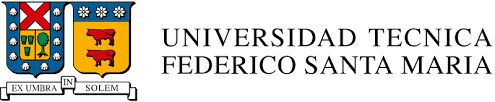</center>



<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477/577 Redes Neuronales Artificiales - 2022-2 </h1>

<H3 align='center'> Tarea 1  </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Manipulaciones en pandas y numpy, imputación de datos y preprocesamientos
* Redes Densas Feed Forward
* Regularización y Dropout
* Vanishing Gradient
* Learn Rate Decay
* Optimizadores


**Formalidades**  
* Equipos de trabajo de 3 personas (*Los estudiantes deben estar preparados para presentar la tarea el día de la entrega*)
* El entregable debe ser un _Jupyter Notebook_ incluyendo los códigos utilizados, los resultados, los gráficos realizados y comentarios. Debe seguir una estructura similar a un informe (se debe introducir los problemas a trabajar, presentar los resultados y discutirlos), se penalizará fuertemente ausencia de comentarios, explicaciones de gráficos, _etc_. Si lo prefiere puede entregar un _Jupyter Notebook_ por pregunta o uno por toda la tarea, con tal de que todos los entregables esten bien identificados y se encuentren en el mismo repositorio de _Github_.
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el _Jupyter Notebook_ que entregarán. 
* Formato de entrega: envı́o de link del repositorio en _Github_, al correo electrónico de los ayudantes (<maryon.morales@sansano.usm.cl>, <sebastian.sanchezl@sansano.usm.cl>), en copia al profesor (<cvalle@inf.utfsm.cl>). Especificar el siguiente asunto: [INF-395/477/577-2022-2 Tarea 1]. Invitar como colaborador a los usuarios de github "ssanchezl" y "maryonmorales" para poder acceder al repositorio en caso de ser privado.

* Fecha de presentaciones 07 de Octubre, en horario de clases.
* Fecha de entrega: 08 de Octubre. Hora límite de entrega: 12:00 p.m. Cualquier _commit_ luego de la hora límite no será evaluado. Se realizará descuento por atrasos en envío del mail igualmente.  

<hr style="height:2px;border:none"/>


* 1 - Redes Feed Forward para predicción de diabetes.

La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo, solo son guias y pueden ser creativos al momento de resolver la tarea. Soluciones creativas o elegantes serán valoradas. También en algunas ocaciones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.
Recuerden intercalar su código con *comentarios* en celdas _Markdown_, con los comentarios de la pregunta y con cualquier análisis, fórmula (en $ \LaTeX $) o explicación que les parezca relevante para justificar sus procedimientos. *No respondan las preguntas en comentarios en el código*.
Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará tanto la elección en si. En cambio la argumentación detrás de la elección será lo más ponderado.
Si algún modelo se demora demasiado en correr en su máquina, no olvide que puede correr _Jupyter Notebooks_ en _Collab_ de Google, incluso con la opción de aceleración con GPU (particularmente útil para los modelos más grandes), esto puede ser relevante para las máquinas más lentas al momento de realizar exploraciones con _K-folds_ o las redes más grandes. Existe también la posibilidad de utilizar _Google Cloud Plataform_ o _Amazon Web Service_, donde tienen máquinas aceleradas con GPU; maquinas ya configuradas para _deep leraning_ pueden encontrarse en el _Marketplace_ de cada proveedor de servicios.

# 1 - Redes Feed Forward para predicción de diabetes

De las redes neuronales artificiales más simples se encuentran las redes densas o Feed Forward, donde todas las neuronas de una capa estan conectadas a todos los inputs y envían su señal de activación a todas las neuronas de la siguiente capa. Estas redes, si bien son las más simples, suelen tener desempeños bastante buenos, y en muchas aplicaciones reales son utilizadas, ya sea por si solas o en combinación con otros modelos. Además, son las redes donde más facil se pueden observar muchos de los fenómenos que se han descubierto a lo largo de los años de desarrollo de esta area del conocimiento, tanto por ser de las redes vigentes más antiguas y por su estructura relativamente simple. En esta primera parte de la tarea exploraremos las redes densas y algunos de sus hiperparámetros más relevantes como la profundidad, el número de unidades; estudiaremos también algunos métodos de regularización y evidenciaremos el problema del vanishing gradient y el exploding gradient, viendo también algunos optimizadores existentes.

Para realizar esto, utilizaremos una base de datos de variables médicas predictoras de la diabetes en mujeres y la variable objetivo (presencia o ausencia de diabetes), la cual se encuentra disponible en Kaggle, en la siguiente URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database. Las variables predictoras incluyen el número de embarazos que ha tenido la paciente, su IMC, el nivel de insulina, la edad, entre otros. Nuesta tarea durante esta pregunta será predecir si la persona tiene o no de diabetes a partir de algunas de las otras variables presentes en el dataset. Para esto primero deberán explorar los atributos del dataset, imputar los valores que falten o eliminarlos en caso que estime conveniente, y luego preprocesar los datos de forma eficiente para que así puedan ser utilizados por una red neuronal. Una vez separados los datos de entrenamiento, validación y test, procederemos a entrenar diferentes modelos, comparandolos y evaluando sus desempeños.

## 1.0 Imports del codigo

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import TerminateOnNaN
from keras.layers import LeakyReLU
from keras.regularizers import l1, l2
from keras.layers import Dropout
from keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
import sklearn.metrics
from sklearn.svm import SVC

## 1.a Carga de datos y primeros análisis
Para cargar los datos, puede descargarlos desde el link de Kaggle, o puede descargarlos desde su jupyter nootebok como muestra el código a continuación. Para obtener más información acerca de como descargar datasets directamente desde la API de Kaggle puede dirigirse a la documentación que se encuentra en el siguiente link: https://github.com/Kaggle/kaggle-api#download-dataset-files. Para usar la API de Kaggle dentro de Google Colab puede serle de utilidad el siguiente link: https://galhever.medium.com/how-to-import-data-from-kaggle-to-google-colab-8160caa11e2.

Luego de descomprimir el archivo descargado cargue los datos en un *Dataframe* como muestra el código. Explore superficialmente los datos utilizando los metodos .head, .describe o .info del *Dataframe*.

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


A continuación se describe el dataset, el cual contiene 9 columnas cada una con 768 datos. Todas las columnas tienen valores numéricos, sin valores nulos.

In [3]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Identifique y comente sobre las características de la variable objetivo (target) que sean relevantes para el problema. ¿Que puede decir acerca de la distribución de las clases?, ¿Están balanceadas? Explique usando gráficos que le parezcan pertinentes para representar el balance de clases. 



### Características de la variable objetivo

In [5]:
df["Outcome"].describe()

count    768.000000
mean       0.348958
std        0.476951
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Outcome, dtype: float64

In [6]:
pos_diab = df[df['Outcome'] != 0]["Outcome"]
neg_diab = df[df['Outcome'] == 0]["Outcome"]

pos_p= len(pos_diab)*100/768
neg_p=100-pos_p

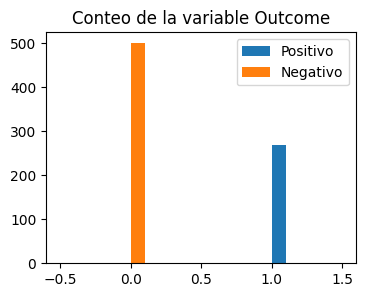

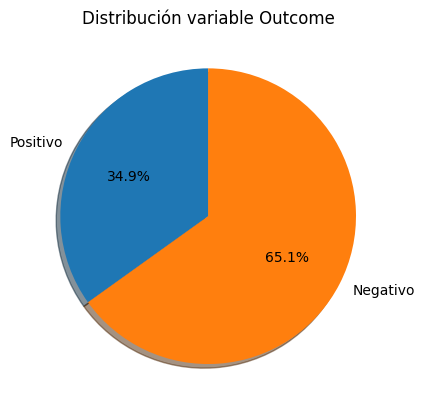

In [7]:


fig, ax = plt.subplots(1, 1, figsize=(4,3),)
plt.title("Conteo de la variable Outcome")
plt.hist(pos_diab, label='Positivo')
plt.hist(neg_diab, label='Negativo')
plt.legend()

labels = ['Positivo', 'Negativo']
sizes = [pos_p, neg_p]

fig1, ax1 = plt.subplots()
plt.title("Distribución variable Outcome")
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()

Se puede observar que la data está desbalanceada, con un 65,1% de resultados negativos respecto a la variable objetivo. Mientras que un 34,9% de resultados positivos

¿Qué puede observar de los datos, tiene sentido que algunos valores de ciertas variables predictoras tengan valor 0?, 

Identifique cuales son las columnas con datos faltantes que fueron imputadas con el valor 0. ¿Tiene sentido estos atributos tengan valores 0? Investigue el rango de valores que puede tomar cada atributo en el dataset, y comente sus principales características.

### Datos faltantes


1. Pregnancies: El rango de valores es normal, desde 0 embarazos hasta 17.
2. Glucose: Existen datos con valor 0, lo cual no tiene sentido ya que los valores normales varían entre 140 a 199 mg/dl
3. Blood Pressure: Existen datos con valor 0, lo cual no tiene sentido ya que los valores normales varían entre 90/60 hacia arriba
4. Skin Thickness: Existen valores 0, lo cual no tiene sentido ya que los valores más bajos son 6 - 2.60 mm
5. Insulina: Existen datos con valor 0, lo cual no tiene sentido ya que sus valores en personas no diabeticas fluctuan entre 60-100 mg/dl
6. BMI: Existen datos con valor 0, los valores normales fluctuan entre 18.5 to 24.9.
7. Función Pedigree Diabetes: No tiene valores 0
8. Edad: Los valores de edad varían entre 21 años hasta 81 años, por lo que están dentro del rango normal

En resumen las variables Glucose, Blood Preassure, Skin Thickness, Insulina, BMI, funcion Pedigree diabetes tiene datos imputados.

In [8]:
for column in df:
    print(column, ": ", len(df[df[column]==0]))

Pregnancies :  111
Glucose :  5
BloodPressure :  35
SkinThickness :  227
Insulin :  374
BMI :  11
DiabetesPedigreeFunction :  0
Age :  0
Outcome :  500


### Características


1. Pregnancies: En promedio las personas tiene aproximadamente 4 embarazos, menos del 25% tiene 1 embarazo o menos.
2. Glucose: En promedio se tiene una glucosa de 120.89 mg/dl (bajo de los rangos normales). Solo un 25% de la muestra está dentro de los rangos normales de glucosa
3. Blood Pressure: Menos de un 25% de personas está en el rango normal de presión arterial. En promedio se tiene un 69.105
4. Skin Thickness: En promedio se tiene un valor de 20.53, y menos del 50% esta en un rango normal.
5. Insulina: El valor promedio es de 79.79 y alrededor del 50% tiene bajo este valor.
6. BMI: El valor promedio es de 31.99, donde alrededor del 25% tiene valores bajo el rango normal.
7. Función Pedigree Diabetes: El valor promedio de la variable es 0.47.
8. Edad: El valor promedio es de 33 años y el 50% esta bajo los 30 años.

## 1.b Train Test Split

En esta pregunta nos ocuparemos de separar el dataset en los conjuntos de entrenamiento, validación y test y estandarizar los datos. Para esto puede utilizar la librería sklearn, en particular la función `train_test_split`. Para esto separe primero el dataset en  $X$  e  $Y$. Luego separe los datos considerando un  70%  de ellos para entrenamiento, un  20%  para validación y un  10%  para test. ¿Qué estamos tratando de representar en esta separación en conjuntos de entrenamiento, validación y test?

In [9]:
X = df.drop(columns=['Outcome'])
y = df["Outcome"]

X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.1, train_size=0.9)
X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=1-(0.7*len(y)/len(y_tr)), train_size=(0.7*len(y)/len(y_tr)))

Objetivo de las divisiones de los datos:
1. Train: Se utiliza para entrenar el modelo (los pesos y bias)
2. Validación: Se utiliza para proveer una evaluación imparacial del modelo mientras se tunean los hiperparámetros
3. Test: Evalua el rendimiento del modelo final

## 1.c Valores faltantes e imputación

Tomando en cuenta solamente el conjunto de entrenamiento, considere los valores imputados con 0 que encontró en la pregunta 1.a y reemplacelos por `NaN`, para esto utilice el método `replace`. Cuente cuantos datos faltantes hay por cada atributo y grafíque. Cree 3 conjuntos de entrenamiento nuevos a partir del resultado de reemplazar con `NaN`:

1.   Conserve el conjunto de entrenamiento original intacto: $X_o$
2.   Reemplace los valores faltantes de cada columna por la media de estos: $X_1$
3.   Reemplace los valores faltantes de cada columna por la mediana de estos: $X_2$
4.   Reemplace los valores faltantes de cada columna utilizando el método MICE [1][2]: $X_3$

Responda las siguientes preguntas:

*   ¿Qué es la imputación de datos?
*   ¿Cuáles son las ventajas y desventajas de los 3 métodos recién utilizados versus sin imputar ($X_o$)?
*   ¿Qué se necesita para ejecutar cada uno de los 3 métodos de imputación de datos?
*   ¿Qué puede decir de los conjuntos resultantes?¿Resuelven el problema de los datos faltantes?





[1] https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.169.5745&rep=rep1&type=pdf

[2] https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html?highlight=mice




In [10]:
X0=X_tr.replace(0,0)
X_tr[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = X_tr[['Glucose',
'BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

X1 =X_tr.fillna(X_tr.mean())
X2 =X_tr.fillna(X_tr.median())

imputer = IterativeImputer(random_state=42)
imputer.fit(X_tr)
imputer=imputer.transform(X_tr)
X3 = pd.DataFrame(imputer, columns = X_tr.columns)

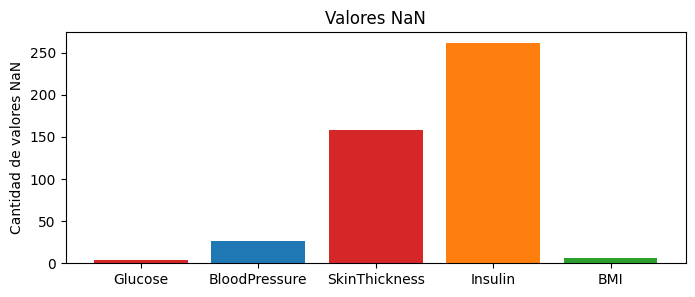

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8,3),)

Column = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
counts = X_tr.isna().sum()[Column]

bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange','tab:green']

ax.bar(Column, counts, color=bar_colors)

ax.set_ylabel('Cantidad de valores NaN')
ax.set_title('Valores NaN')

plt.show()

El gráfico muestra la cantidad de valores NaN para cada una de las columnas imputadas, se puede notar que hay una mayor cantidad de datos faltantes para la información de la Insulina y la columna SkinThickness.

A continuación se muestran la nueva descripción de la data para cada uno de los dataset creados.

In [12]:
X0.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,3.832402,119.186220,68.154562,20.476723,76.964618,31.967225,0.467061,33.260708
std,3.366571,32.131997,19.529072,15.740192,108.203187,7.824472,0.319596,11.985338
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,98.000000,62.000000,0.000000,0.000000,26.800000,0.238000,24.000000
50%,3.000000,114.000000,70.000000,23.000000,29.000000,32.000000,0.376000,29.000000
75%,6.000000,139.000000,78.000000,32.000000,126.000000,36.400000,0.627000,40.000000
max,15.000000,198.000000,122.000000,63.000000,744.000000,67.100000,2.420000,81.000000


In [13]:
X1.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,3.832402,120.080675,71.622309,29.013193,149.746377,32.328437,0.467061,33.260708
std,3.366571,30.424654,12.025013,8.522242,78.075980,7.046551,0.319596,11.985338
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,25.000000,120.000000,27.100000,0.238000,24.000000
50%,3.000000,114.000000,71.622309,29.013193,149.746377,32.328437,0.376000,29.000000
75%,6.000000,139.000000,78.000000,32.000000,149.746377,36.400000,0.627000,40.000000
max,15.000000,198.000000,122.000000,63.000000,744.000000,67.100000,2.420000,81.000000


In [14]:
X2.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,3.832402,120.035382,71.640596,29.009311,137.718808,32.328119,0.467061,33.260708
std,3.366571,30.429155,12.025287,8.522244,79.051378,7.046552,0.319596,11.985338
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,25.000000,120.000000,27.100000,0.238000,24.000000
50%,3.000000,114.000000,72.000000,29.000000,125.000000,32.300000,0.376000,29.000000
75%,6.000000,139.000000,78.000000,32.000000,126.000000,36.400000,0.627000,40.000000
max,15.000000,198.000000,122.000000,63.000000,744.000000,67.100000,2.420000,81.000000


In [15]:
X3.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,3.832402,120.005279,71.545617,28.652385,145.584309,32.318263,0.467061,33.260708
std,3.366571,30.466686,12.080650,9.334340,89.705692,7.047755,0.319596,11.985338
min,0.000000,44.000000,24.000000,7.000000,-14.584416,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,22.000000,86.994401,27.100000,0.238000,24.000000
50%,3.000000,114.000000,70.994120,28.014228,126.000000,32.269841,0.376000,29.000000
75%,6.000000,139.000000,79.206069,35.000000,182.000000,36.400000,0.627000,40.000000
max,15.000000,198.000000,122.000000,63.000000,744.000000,67.100000,2.420000,81.000000


### Respuestas
1. La imputacion de datos corresponde a la sustitucion de datos no observados por otros, en el sentido de que en la toma de datos estos no fueron observados por lo tanto ese campo se rellena con algún valor.
2. En base a los valores mostrados en la tabla de resumen, vemos lo siguiente: 
    Al aplicar el primer metodo de imputacion vemos como los promedios de las variables se mantienen respecto a los del dataset original pero la desviasion estandar de las varibles disminuye considerablemente (si se toma en cuenta la cantidad de valores Nan que habia en el dataset original). 
    Respecto al segundo metodo de imputación, vemos una disminucion en los valores del promedio y de la desviacion estantar.
    Finalmente, respecto al tercer metodo vemos que nuevamente el promedio y la desviacion estadar varian en comparacion al dataset original pero de una forma diferente a los metodos anteriores, la desviacion estandar disminuye pero no de una forma tan considerable que los metodos anteriores y el promedio en varias variables es inferior al que arroja los metodos anteriores pero suele ser un valor cercano al promedio del dataset original.
    Las mayores variaciones respecto al dataset original se producen en las variables que poseian una mayor cantidad de valores Nan.
3. Para el primer metodo se requiere el promedio de la variable, el segundo requiere la mediana de la variables, ambos metodos requieren que los valores de las variables sean numeros reales. El tercer metodo que usamos requiere ...
4. Todos los metodos resuelven el problema de la imputacion de datos para este dataset, ya que a todas las variables afectadas son variables numericas, por lo tanto es posible calcularles los elementos necesarios.

#### Tabla de resumen 
Forma de lectura: (X_0, X_1, X_2, X_3)

> 1. Glucosa mean = (122.31, 122.31, 122.26, 122.24)
> 2. Glucosa std = (30.77, 30.63, 30.63, 30.67)

> 1. BloodPreasure mean = (72.66, 72.66, 72.63, 72.60)
> 2. BloodPreasure std = (12.63, 12.38, 12.38, 12.43)

> 1. SkinThickness mean = (28.91, 28.91, 28.93, 28.84)
> 2. SkinThickness std = (10.70, 8.99, 8.99, 9.64)

> 1. Insulin mean = (157.49, 157.49, 142.12, 155.29)
> 2. Insulin std = (122.67, 87.71, 89.11, 100.53)

> 1. BMI mean = (32.50, 32.50, 32.50, 32.50)
> 2. BMI std = (6.95, 6.89, 6.89, 6.89)

## 1.d Estandarización

`Nota:` A menos que se indique explícitamente lo contrario, en esta y las siguientes preguntas realice los siguientes procedimientos y entrene las redes considerando como conjunto de entrenamiento cada $X \in \{X_o, X_1, X_2, X_3\}$ obtenido en la imputación anterior y comente las diferencias que observa en los desempeños de sus redes.

Ajuste los scalers con los datos de entrenamiento y transforme los datos para cada conjunto obtenido en la pregunta anterior.

- ¿Qué operación matemática realiza `StandarScaler` al momento de tranformar los datos? 
- ¿Por qué debemos transformar los datos de validación y de test con el _scaler_ ajustado a los datos de entrenamiento? 

In [16]:
##X0
scaler_xo = StandardScaler()
scaler_xo.fit(X0)
x_tr_o = scaler_xo.transform(X0)
x_val_o = scaler_xo.transform(X_val)

##X1
scaler_x1 = StandardScaler()
scaler_x1.fit(X1)
x_tr_1 = scaler_x1.transform(X1)
x_val_1 = scaler_x1.transform(X_val)

##X2
scaler_x2 = StandardScaler()
scaler_x2.fit(X2)
x_tr_2 = scaler_x2.transform(X2)
x_val_2 = scaler_x2.transform(X_val)

##X3
scaler_x3 = StandardScaler()
scaler_x3.fit(X3)
x_tr_3 = scaler_x3.transform(X3)
x_val_3 = scaler_x3.transform(X_val)


### Respuestas
1. StandarScaler realiza la extraccion del promedio de la variable a cada elemento y el resultado de la operacion es reescalado a la varianza unitaria.
2. La razon por la que es necesario transformar los datos es porque estos, originalmente presetan diferentes escalas lo cual deriva a un resultado sesgado (un error en la precision). 

[1] https://www.digitalocean.com/community/tutorials/standardscaler-function-in-python

## 1.e Primera Red
En esta pregunta construiremos y entrenaremos una primera red neuronal. Para esto utilizaremos la librería keras que se ocupa de crear, compilar y entrenar los modelos de manera simple. Keras se encargará por lo tanto de crear los modelos y al momento de compilarlos se instanciarán estos en una sesión de TensorFlow. 

Esta primera red será una red de una capa oculta con $256$ neuronas, activación ReLu. Para esta red y todas las demas utilizaremos la función de pérdida _Binary Cross Entropy_ ¿Porqué se ocupa esta función de pérdida?¿Qué función de activación se utiliza para la capa de salida en este tipo de problemas?¿Cuántas neuronas para la capa de salida?. Para entrenar esta primera red utilizaremos Gradiente Descendente Estocástico con un _Learn Rate_ de 0.002. Finalmente entrenaremos esta red por unas 20 _epochs_.

Construya la red basandose en el siguiente código y en la documentación de keras. 

In [17]:
ANN = Sequential()
ANN.add(Dense(units = 256, activation = 'relu'))
ANN.add(Dense(units = 1,activation='sigmoid'))
ANN.compile(optimizer=SGD(learning_rate=0.002),loss='binary_crossentropy')

In [18]:
def SDG(lr):
    model=Sequential()
    model.add(Dense(units = 256, activation = 'relu'))
    model.add(Dense(units = 1,activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

### Respuesta

1. Porque este tipo de funciones nos permite comprobar el rendimiento de nuestra red para clasificar elementos de forma binaria.
2. Para este problema de clasificación binario, la funcion de activacion utilziada es la funcion sigmoidal.
3. Para la capa de salida solo tendremos una neurona, ya que estamos trabajando con una clasificación binaria.

### Dataset X0

In [19]:
m1_o= SDG(0.002)

Entrene la red por 20 _epochs_, guardando el `history` que retorna el metodo `.fit`.

In [20]:
history1_o = m1_o.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

Epoch 1/20
17/17 [==============================] - 1s 21ms/step - loss: 0.6941 - val_loss: 0.6945
Epoch 2/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6878 - val_loss: 0.6897
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6817 - val_loss: 0.6850
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6758 - val_loss: 0.6805
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6703 - val_loss: 0.6761
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6649 - val_loss: 0.6719
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6597 - val_loss: 0.6678
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6547 - val_loss: 0.6639
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6499 - val_loss: 0.6601
Epoch 10/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6453 - val_loss: 0.6564
Epoch 11/20
17/17 

Utilice el método `.summary` para ver el número de parámetros de su red y los tamaños de cada capa. 

Explique el número de parámetros presentes en esta red, es decir: ¿Cómo a partir de la dimensión del _Input_ y el número de neuronas obtenemos ese número de parámetros?

In [21]:
m1_o.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               2304      
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________


Para la primera capa se tiene 2304 parámetros y 256 neuronas que dan una salida. El input tiene 9 datos, que corresponde a la cantidad de columnas del dataset, luego, cada uno de esos se da como entrada a las 256 neuronas. Lo que lleva a un total de 2304 parámetros.

Grafique como varian los errores de validación y de entrenamiento a lo largo de las _epochs_. Comente.

### DataSet X0

##### Learning rate 0.002

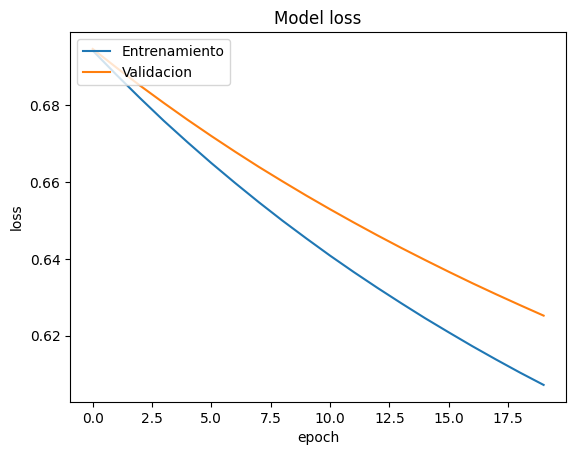

In [22]:
#Grafique como varian los errores de validación y de entrenamiento a lo largo de las epochs. Comente
plt.plot(history1_o.history['loss'])
plt.plot(history1_o.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Entrenamiento', 'Validacion'], loc='upper left')
plt.show()

Cree y entrene nuevamente la red, esta vez cambiando el _learn rate_ utilizado para el SGD. Pruebe a lo menos un valor mayor y un valor menor al elegido anteriormente. Note que para valores mayores al propuesto puede comenzar a observar fenómeno de divergencia, por lo cual es recomendable agregarle a la red un _callback_, es decir una función que verifica estados y comportamientos de la red mientras se entrena, en particular `TerminateOnNaN`, el cual interrumpirá el proceso de entrenamiento si encuentra un valor NaN. 

Grafique el comportamiento de los errores de validación y entrenamiento y comente.

##### Learning rate 0.009

In [23]:
m2_o= SDG(0.009)
history2_o = m2_o.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

Epoch 1/20
17/17 [==============================] - 1s 23ms/step - loss: 0.6881 - val_loss: 0.6699
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6609 - val_loss: 0.6506
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6391 - val_loss: 0.6348
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6213 - val_loss: 0.6214
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6062 - val_loss: 0.6100
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5935 - val_loss: 0.5999
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5822 - val_loss: 0.5912
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5725 - val_loss: 0.5833
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5640 - val_loss: 0.5762
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5564 - val_loss: 0.5697
Epoch 11/20
17/17 

##### Learning rate 0.009 - Terminate On NaN

In [24]:
m3_o= SDG(0.009)
history3_o = m3_o.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val),
                     callbacks=[TerminateOnNaN()]
                     )

Epoch 1/20
17/17 [==============================] - 1s 15ms/step - loss: 0.6487 - val_loss: 0.6358
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6297 - val_loss: 0.6210
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6137 - val_loss: 0.6081
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5998 - val_loss: 0.5966
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5877 - val_loss: 0.5865
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5771 - val_loss: 0.5775
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5678 - val_loss: 0.5693
Epoch 8/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5594 - val_loss: 0.5618
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5518 - val_loss: 0.5550
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5451 - val_loss: 0.5488
Epoch 11/20
17/17 

##### Learning rate 0.0002

In [25]:
m4_o= SDG(0.0002)
history4_o = m4_o.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

Epoch 1/20
17/17 [==============================] - 1s 16ms/step - loss: 0.6898 - val_loss: 0.6904
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6892 - val_loss: 0.6898
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6885 - val_loss: 0.6893
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6878 - val_loss: 0.6887
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6872 - val_loss: 0.6882
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6865 - val_loss: 0.6876
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6859 - val_loss: 0.6871
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6852 - val_loss: 0.6866
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6846 - val_loss: 0.6860
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6840 - val_loss: 0.6855
Epoch 11/20
17/17 

##### Graficos comparativos

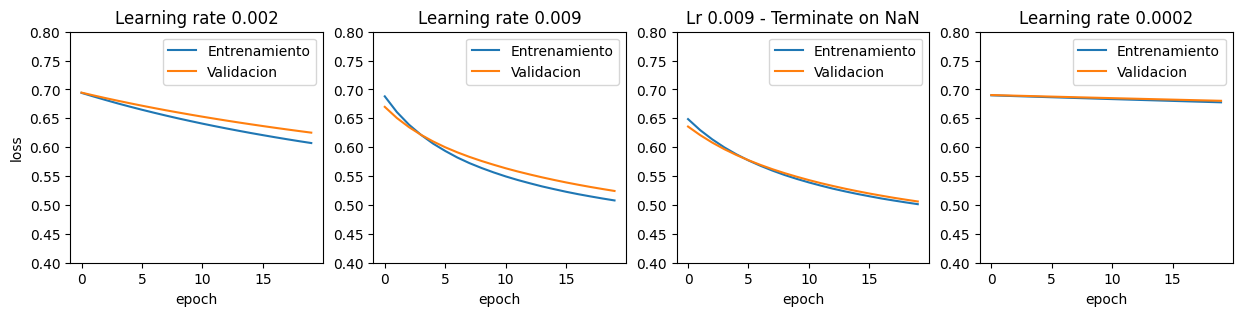

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(15,3),)
aux = [history1_o, history2_o, history3_o,history4_o]

for i in range(len(aux)):
    ax[i].plot(aux[i].history['loss'])
    ax[i].plot(aux[i].history['val_loss'])
    ax[i].legend(['Entrenamiento', 'Validacion'], loc='upper right')
    ax[i].set_ylim(0.4, 0.8)
    ax[i].set_xlabel('epoch')
    
ax[0].set_title('Learning rate 0.002')
ax[1].set_title('Learning rate 0.009')
ax[2].set_title('Lr 0.009 - Terminate on NaN')
ax[3].set_title('Learning rate 0.0002')
ax[0].set_ylabel('loss')
plt.show()

De los gráficos se puede observar que el mejor resultado para el dataset $X_0$ se obtiene para un Learning rate 0.009 terminate on Nan, los otros si bien muestran tendencias similares el error disminuye muy lentamente. Para dar una respuesta mas certera es necesario aumentar el numero de epochs.

### Dataset X1

##### Learning rate 0.002

In [27]:
m1_1= SDG(0.002)
history1_1 = m1_1.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))

Epoch 1/20
17/17 [==============================] - 1s 15ms/step - loss: 0.6699 - val_loss: 0.6734
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6634 - val_loss: 0.6695
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6571 - val_loss: 0.6659
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6511 - val_loss: 0.6626
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6455 - val_loss: 0.6595
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6400 - val_loss: 0.6567
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6348 - val_loss: 0.6542
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6298 - val_loss: 0.6518
Epoch 9/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6250 - val_loss: 0.6497
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6204 - val_loss: 0.6477
Epoch 11/20
17/17 

##### Learning rate 0.009

In [28]:
m2_1= SDG(0.009)
history2_1 = m2_1.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))
m2_1.summary()

Epoch 1/20
17/17 [==============================] - 1s 16ms/step - loss: 0.6519 - val_loss: 0.6474
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6274 - val_loss: 0.6350
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6074 - val_loss: 0.6266
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5905 - val_loss: 0.6209
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5765 - val_loss: 0.6173
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5645 - val_loss: 0.6149
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5539 - val_loss: 0.6135
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5447 - val_loss: 0.6127
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5366 - val_loss: 0.6126
Epoch 10/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5294 - val_loss: 0.6123
Epoch 11/20
17/17 

##### Learning rate 0.009 - Terminate On NaN

In [29]:
m4_1= SDG(0.009)
history4_1 = m4_1.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val),
                     callbacks=[TerminateOnNaN()]
                     )

Epoch 1/20
17/17 [==============================] - 1s 15ms/step - loss: 0.7035 - val_loss: 0.6940
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6649 - val_loss: 0.6712
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6350 - val_loss: 0.6571
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6111 - val_loss: 0.6488
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5916 - val_loss: 0.6441
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5756 - val_loss: 0.6417
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5622 - val_loss: 0.6408
Epoch 8/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5508 - val_loss: 0.6408
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5411 - val_loss: 0.6415
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5324 - val_loss: 0.6424
Epoch 11/20
17/17 

##### Learning rate 0.0002

In [30]:
m3_1= SDG(0.0002)
history3_1 = m3_1.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))
m3_1.summary()

Epoch 1/20
17/17 [==============================] - 1s 15ms/step - loss: 0.7250 - val_loss: 0.7218
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7241 - val_loss: 0.7210
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.7232 - val_loss: 0.7202
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.7223 - val_loss: 0.7193
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.7215 - val_loss: 0.7185
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7206 - val_loss: 0.7177
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7197 - val_loss: 0.7169
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7189 - val_loss: 0.7161
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7180 - val_loss: 0.7153
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7171 - val_loss: 0.7145
Epoch 11/20
17/17 

##### Graficos comparativos

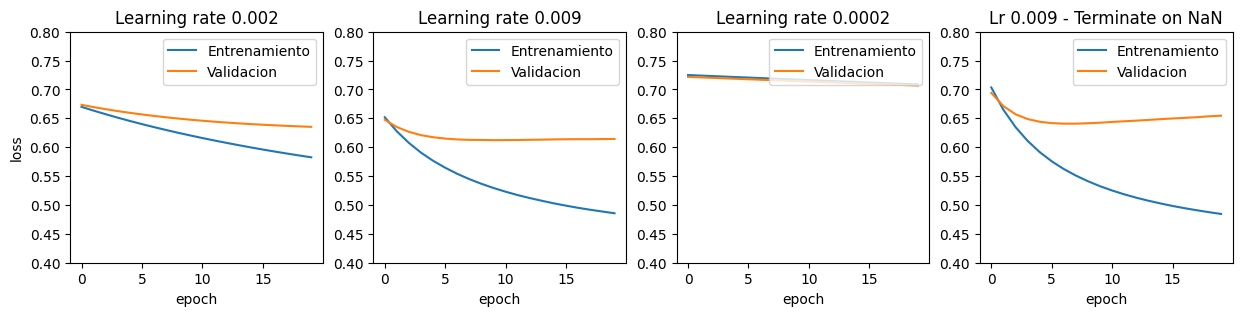

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(15,3),)
aux = [history1_1, history2_1, history3_1, history4_1]

for i in range(len(aux)):
    ax[i].plot(aux[i].history['loss'])
    ax[i].plot(aux[i].history['val_loss'])
    ax[i].legend(['Entrenamiento', 'Validacion'], loc='upper right')
    ax[i].set_ylim(0.4, 0.8)
    ax[i].set_xlabel('epoch')
    
ax[0].set_title('Learning rate 0.002')
ax[1].set_title('Learning rate 0.009')
ax[2].set_title('Learning rate 0.0002')
ax[3].set_title('Lr 0.009 - Terminate on NaN')
ax[0].set_ylabel('loss')
plt.show()

De los gráficos se puede observar que el mejor resultado para el dataset $X_1$ se obtiene para un Learning rate 0.002, en los valores mas altos se puede observar un overfitting ya que la curva de validacion empieza a diverger respecto a la de entrenamiento, por otro lado para valores muy pequeños se ve una disminucion muy lenta.

### Dataset X2

##### Learning rate 0.002

In [32]:
m1_2= SDG(0.002)
history1_2 = m1_2.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))
m1_2.summary()

Epoch 1/20
17/17 [==============================] - 1s 15ms/step - loss: 0.6691 - val_loss: 0.6755
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6622 - val_loss: 0.6712
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6556 - val_loss: 0.6672
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6493 - val_loss: 0.6635
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6433 - val_loss: 0.6602
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6375 - val_loss: 0.6571
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6319 - val_loss: 0.6544
Epoch 8/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6267 - val_loss: 0.6518
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6216 - val_loss: 0.6495
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6167 - val_loss: 0.6474
Epoch 11/20
17/17 

##### Learning rate 0.009

In [33]:
m2_2= SDG(0.009)
history2_2 = m2_2.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))

Epoch 1/20
17/17 [==============================] - 1s 14ms/step - loss: 0.6751 - val_loss: 0.6960
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6482 - val_loss: 0.6813
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6259 - val_loss: 0.6709
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6074 - val_loss: 0.6638
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5913 - val_loss: 0.6586
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5777 - val_loss: 0.6548
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5657 - val_loss: 0.6521
Epoch 8/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5552 - val_loss: 0.6500
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5460 - val_loss: 0.6486
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5378 - val_loss: 0.6477
Epoch 11/20
17/17 

##### Learning rate 0.009 - Terminate On NaN

In [34]:
m4_2= SDG(0.009)
history4_2 = m4_2.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val), callbacks=[TerminateOnNaN()] )

Epoch 1/20
17/17 [==============================] - 1s 15ms/step - loss: 0.6708 - val_loss: 0.6639
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6438 - val_loss: 0.6469
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6215 - val_loss: 0.6348
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6027 - val_loss: 0.6259
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5868 - val_loss: 0.6197
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5731 - val_loss: 0.6152
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5611 - val_loss: 0.6122
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5507 - val_loss: 0.6102
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5416 - val_loss: 0.6091
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5337 - val_loss: 0.6083
Epoch 11/20
17/17 

##### Learning rate 0.0002

In [35]:
m3_2= SDG(0.0002)
history3_2 = m3_2.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))

Epoch 1/20
17/17 [==============================] - 1s 15ms/step - loss: 0.7170 - val_loss: 0.7292
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7161 - val_loss: 0.7282
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7152 - val_loss: 0.7273
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7143 - val_loss: 0.7263
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.7134 - val_loss: 0.7254
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.7125 - val_loss: 0.7245
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7117 - val_loss: 0.7235
Epoch 8/20
17/17 [==============================] - 0s 4ms/step - loss: 0.7108 - val_loss: 0.7226
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7099 - val_loss: 0.7217
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7091 - val_loss: 0.7208
Epoch 11/20
17/17 

##### Graficos

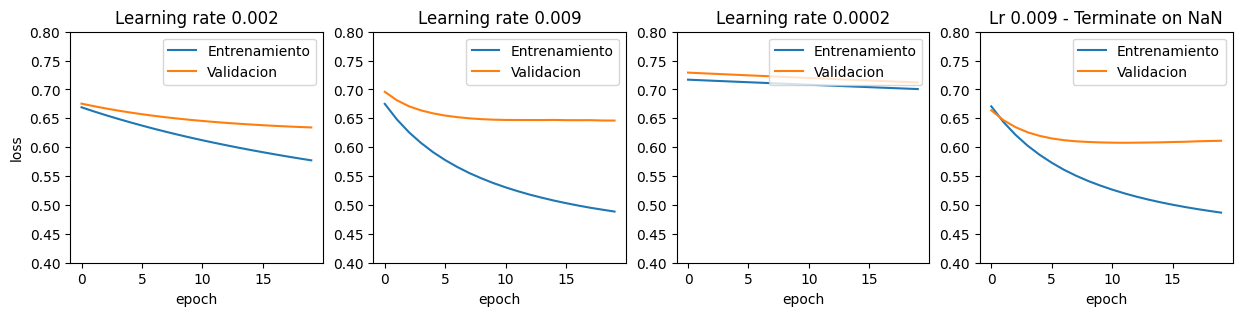

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(15,3),)
aux = [history1_2, history2_2, history3_2, history4_2]

for i in range(len(aux)):
    ax[i].plot(aux[i].history['loss'])
    ax[i].plot(aux[i].history['val_loss'])
    ax[i].legend(['Entrenamiento', 'Validacion'], loc='upper right')
    ax[i].set_ylim(0.4, 0.8)
    ax[i].set_xlabel('epoch')
    
ax[0].set_title('Learning rate 0.002')
ax[1].set_title('Learning rate 0.009')
ax[2].set_title('Learning rate 0.0002')
ax[3].set_title('Lr 0.009 - Terminate on NaN')
ax[0].set_ylabel('loss')
plt.show()

De los gráficos se puede observar que el mejor resultado para el dataset $X_2$ se obtiene para un Learning rate 0.002, al igual que en el dataset $X_1$ se observa que para valores altos de learning rate ocurre un fenomeno de overfitting mientras que para valores pequeños la disminucion del error es muy lenta.

### Dataset X3

##### Learning rate 0.002

In [37]:
m1_3= SDG(0.002)
history1_3 = m1_3.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
m1_3.summary()

Epoch 1/20
17/17 [==============================] - 1s 15ms/step - loss: 0.6662 - val_loss: 0.6792
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6580 - val_loss: 0.6738
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6503 - val_loss: 0.6689
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6430 - val_loss: 0.6644
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6360 - val_loss: 0.6603
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6294 - val_loss: 0.6566
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6232 - val_loss: 0.6532
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6172 - val_loss: 0.6501
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6115 - val_loss: 0.6473
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6062 - val_loss: 0.6448
Epoch 11/20
17/17 

##### Learning rate 0.009

In [38]:
m2_3= SDG(0.002)
history2_3 = m2_3.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
m2_3.summary()

Epoch 1/20
17/17 [==============================] - 1s 18ms/step - loss: 0.6799 - val_loss: 0.6839
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6724 - val_loss: 0.6786
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6652 - val_loss: 0.6737
Epoch 4/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6584 - val_loss: 0.6692
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6519 - val_loss: 0.6650
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6457 - val_loss: 0.6611
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6398 - val_loss: 0.6576
Epoch 8/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6341 - val_loss: 0.6542
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6286 - val_loss: 0.6511
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6234 - val_loss: 0.6483
Epoch 11/20
17/17 

##### Learning rate 0.009 - Terminate On NaN

In [39]:
m4_3= SDG(0.009)
history4_3 = m4_3.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val), callbacks=[TerminateOnNaN()] )

Epoch 1/20
17/17 [==============================] - 1s 15ms/step - loss: 0.7539 - val_loss: 0.7216
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6999 - val_loss: 0.6805
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6590 - val_loss: 0.6536
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6273 - val_loss: 0.6367
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6025 - val_loss: 0.6260
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5826 - val_loss: 0.6199
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5665 - val_loss: 0.6167
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5532 - val_loss: 0.6155
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5422 - val_loss: 0.6157
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5327 - val_loss: 0.6167
Epoch 11/20
17/17 

##### Learning rate 0.0002

In [40]:
m3_3= SDG(0.002)
history3_3 = m3_3.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
m3_3.summary()

Epoch 1/20
17/17 [==============================] - 1s 15ms/step - loss: 0.6799 - val_loss: 0.6773
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6720 - val_loss: 0.6718
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6645 - val_loss: 0.6667
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6574 - val_loss: 0.6620
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6506 - val_loss: 0.6576
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6441 - val_loss: 0.6535
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6378 - val_loss: 0.6497
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6319 - val_loss: 0.6462
Epoch 9/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6262 - val_loss: 0.6429
Epoch 10/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6207 - val_loss: 0.6399
Epoch 11/20
17/17 

##### Graficos

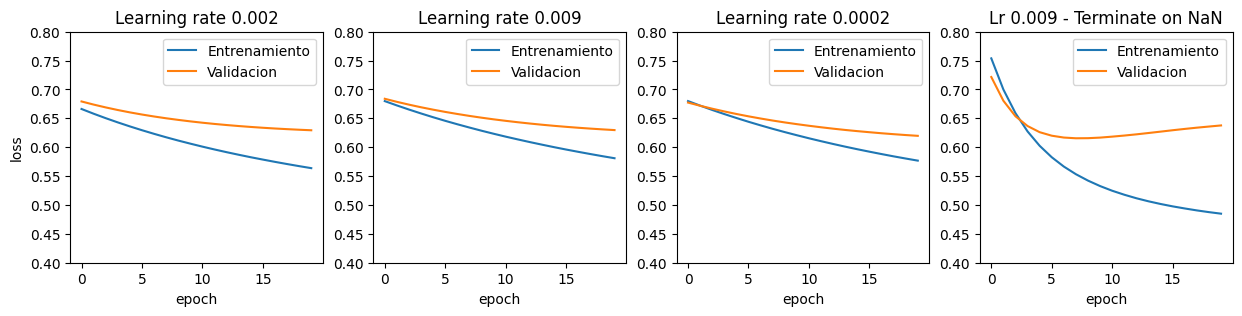

In [41]:
fig, ax = plt.subplots(1, 4, figsize=(15,3),)
aux = [history1_3, history2_3, history3_3, history4_3]

for i in range(len(aux)):
    ax[i].plot(aux[i].history['loss'])
    ax[i].plot(aux[i].history['val_loss'])
    ax[i].legend(['Entrenamiento', 'Validacion'], loc='upper right')
    ax[i].set_ylim(0.4, 0.8)
    ax[i].set_xlabel('epoch')
    
ax[0].set_title('Learning rate 0.002')
ax[1].set_title('Learning rate 0.009')
ax[2].set_title('Learning rate 0.0002')
ax[3].set_title('Lr 0.009 - Terminate on NaN')
ax[0].set_ylabel('loss')
plt.show()

En los graficos se puede observar que para el dataset $X_3$ se observa que el mejor rendimiento se obtiene con un learning rate de $0.0002$, donde solo se observa un fenomeno de overfitting para un learning rate de $0.009$ con terminate on Nan. En este dataset se puede ver que las curvas en general se parecen mucho, para obtener una mejor comparación es necesario aumentar el numero de epochs.

### Graficos comparativos

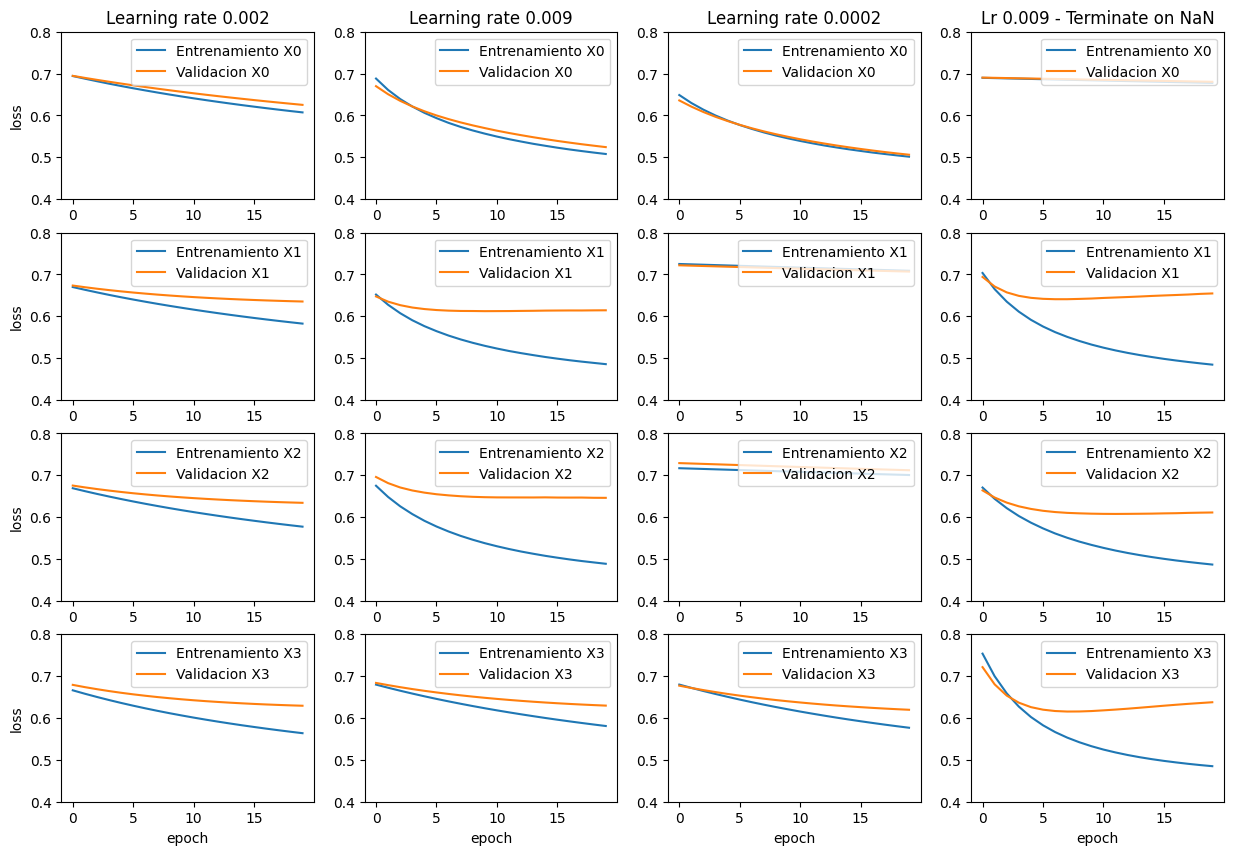

In [42]:
fig, ax = plt.subplots(4, 4, figsize=(15,10),)
aux = [[history1_o, history2_o, history3_o, history4_o], 
       [history1_1, history2_1, history3_1, history4_1], 
       [history1_2, history2_2, history3_2, history4_2], 
       [history1_3, history2_3, history3_3, history4_3] ]
aux2 = ["X0","X1", "X2", "X3"]

for i in range(len(aux)):
    for j in range(len(aux)):
        ax[i,j].plot(aux[i][j].history['loss'])
        ax[i,j].plot(aux[i][j].history['val_loss'])
        ax[i,j].legend(['Entrenamiento ' + aux2[i], 'Validacion ' + aux2[i]], loc='upper right')
        ax[i,j].set_ylim(0.4, 0.8)
    
ax[0,0].set_title('Learning rate 0.002')
ax[0,1].set_title('Learning rate 0.009')
ax[0,2].set_title('Learning rate 0.0002')
ax[0,3].set_title('Lr 0.009 - Terminate on NaN')
ax[3,0].set_xlabel('epoch')
ax[3,1].set_xlabel('epoch')
ax[3,2].set_xlabel('epoch')
ax[3,3].set_xlabel('epoch')
ax[0,0].set_ylabel('loss')
ax[1,0].set_ylabel('loss')
ax[2,0].set_ylabel('loss')
ax[3,0].set_ylabel('loss')
plt.show()

En general, para todos los conjuntos, los mejores resultados se obtienen para valores de learning rate bajos, para valores altos, se puede observar como ocurre un fenomeno de overfitting en la mayoria de los escenarios. Por otro lado seria necesario un major numero de epoch para poder concluir cual valor, entre $0.002$ y $0.0002$ , tiene mejor rendimiento.

## 1.f Activación y regularizadores $l1$ $l2$
En esta pregunta se les propone explorar distintas funciones de activación y de regularización. En ambos casos debe entrenar la misma red entrenada anteriormente utilizando gradiente descendente estocástico con algun _learn rate_ que le parezca adecuado luego de la exploración en la pregunta anterior. 

* Para explorar distintas funciones de activación, cambie la activación de la capa oculta sucesivamente por: tangente hiperbólica, _Leaky ReLu_, sigmoidea y lineal. Para esto puede basarse en el código presentado abajo y la documentación de keras. Para la activación _Leaky ReLu_ pruebe cambiar el parámetro de la red. Describa sus resultados y si observa diferencias entre las redes. 

¿Para qué se usan activaciones no lineales? ¿Le parece buena opción la activación sigmoidea para la capa oculta?

¿Cual es la intención de la regularización en general? En particular, ¿Que restricción implicita imponen las regularizaciones $l$1 o $l$2 sobre los pesos de la capa en la cual se aplican? Apoyese de ecuaciones.

In [43]:
def Active(lr,activation):
    model=Sequential()
    model.add(Dense(units = 256, activation = activation))
    model.add(Dense(units = 1,activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

### Respuestas

1. Los activadores no lineales se usan en problemas de clasificacion. Como estamos trabajando con un problema de clasficicacion binaria, el uso de la funcion sigmoidal parece una opcion aceptable dentro de las funciones no lineales.

2. La regularización se usa para controlar los valores de los pesos que se calculan en la red, esto para impedir el overfitting.

### Dataset X0

In [44]:
learning_r=0.009

In [45]:
model1 = Active(learning_r,'linear')
history1 = model1.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

Epoch 1/20
17/17 [==============================] - 1s 14ms/step - loss: 0.6599 - val_loss: 0.6359
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6157 - val_loss: 0.6035
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5858 - val_loss: 0.5805
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5645 - val_loss: 0.5631
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5484 - val_loss: 0.5494
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5357 - val_loss: 0.5383
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5257 - val_loss: 0.5289
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5171 - val_loss: 0.5206
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5099 - val_loss: 0.5132
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5039 - val_loss: 0.5071
Epoch 11/20
17/17 

In [46]:
model2 = Active(learning_r,'tanh')
history2 = model2.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

Epoch 1/20
17/17 [==============================] - 1s 15ms/step - loss: 0.6186 - val_loss: 0.5970
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5862 - val_loss: 0.5727
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5628 - val_loss: 0.5547
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5456 - val_loss: 0.5404
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5322 - val_loss: 0.5292
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5218 - val_loss: 0.5196
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5131 - val_loss: 0.5116
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5061 - val_loss: 0.5047
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5003 - val_loss: 0.4988
Epoch 10/20
17/17 [==============================] - 0s 4ms/step - loss: 0.4952 - val_loss: 0.4935
Epoch 11/20
17/17 

In [47]:
model3 = Active(learning_r,'sigmoid')
history3 = model3.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

Epoch 1/20
17/17 [==============================] - 1s 15ms/step - loss: 0.6424 - val_loss: 0.6562
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6389 - val_loss: 0.6541
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6341 - val_loss: 0.6495
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6303 - val_loss: 0.6458
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6277 - val_loss: 0.6422
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6237 - val_loss: 0.6390
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6205 - val_loss: 0.6363
Epoch 8/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6169 - val_loss: 0.6336
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6149 - val_loss: 0.6310
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6101 - val_loss: 0.6267
Epoch 11/20
17/17 

In [48]:
model4 = Sequential()

# Hidden Layer
model4.add(
    Dense(
        units = 256, 
        activation = LeakyReLU()
    )
)

# Output Layer
model4.add(
    Dense(
       units = 1,
       activation='sigmoid'
    )
)


model4.compile(
    optimizer=SGD(learning_rate=learning_r),
    loss='binary_crossentropy'
)
history4 = model4.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

Epoch 1/20
17/17 [==============================] - 1s 20ms/step - loss: 0.6650 - val_loss: 0.6465
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6339 - val_loss: 0.6231
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6089 - val_loss: 0.6040
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5885 - val_loss: 0.5887
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5721 - val_loss: 0.5756
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5583 - val_loss: 0.5644
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5468 - val_loss: 0.5548
Epoch 8/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5369 - val_loss: 0.5465
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5286 - val_loss: 0.5392
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5215 - val_loss: 0.5327
Epoch 11/20
17/17 

Podemos notar que para el DataSet X0 no fue posible ajustar el modelo debido a los valores nan en cada columna.

### Dataset X1

In [49]:
model1 = Active(learning_r,'linear')
history1 = model1.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))

Epoch 1/20
17/17 [==============================] - 1s 15ms/step - loss: 0.7311 - val_loss: 0.6686
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6350 - val_loss: 0.6008
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5817 - val_loss: 0.5679
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5504 - val_loss: 0.5504
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5293 - val_loss: 0.5408
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5155 - val_loss: 0.5343
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5059 - val_loss: 0.5292
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4982 - val_loss: 0.5253
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4924 - val_loss: 0.5223
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4877 - val_loss: 0.5190
Epoch 11/20
17/17 

In [50]:
model2 = Active(learning_r,'tanh')
history2 = model2.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))

Epoch 1/20
17/17 [==============================] - 1s 14ms/step - loss: 0.6783 - val_loss: 0.6793
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6259 - val_loss: 0.6488
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5911 - val_loss: 0.6294
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5665 - val_loss: 0.6152
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5485 - val_loss: 0.6044
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5345 - val_loss: 0.5959
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5234 - val_loss: 0.5881
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5144 - val_loss: 0.5814
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5073 - val_loss: 0.5759
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5011 - val_loss: 0.5707
Epoch 11/20
17/17 

In [51]:
model3 = Active(learning_r,'sigmoid')
history3 = model3.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))

Epoch 1/20
17/17 [==============================] - 1s 15ms/step - loss: 0.6876 - val_loss: 0.6563
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6452 - val_loss: 0.6523
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6412 - val_loss: 0.6490
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6363 - val_loss: 0.6450
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6332 - val_loss: 0.6392
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6291 - val_loss: 0.6360
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6256 - val_loss: 0.6325
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6199 - val_loss: 0.6309
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6168 - val_loss: 0.6296
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6129 - val_loss: 0.6248
Epoch 11/20
17/17 

In [52]:
def Relu(a):
    model = Sequential()
    model.add(Dense(units = 256))
    model.add(LeakyReLU(alpha=a))
    model.add(Dense(units = 1,activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=learning_r),loss='binary_crossentropy')
    return model

In [53]:
RegVal = [0.01,0.0002,0.2,0.3,0.5]
minLoss1 = []
minTrain1 = []

for i in RegVal:
    model4 = Relu(i)
    history4 = model4.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))
    minLoss1.append(history4.history['val_loss'][19])
    minTrain1.append(history4.history['loss'][19])

Epoch 1/20
17/17 [==============================] - 1s 15ms/step - loss: 0.6776 - val_loss: 0.6998
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6498 - val_loss: 0.6834
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6267 - val_loss: 0.6709
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6070 - val_loss: 0.6616
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5901 - val_loss: 0.6543
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5760 - val_loss: 0.6487
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5635 - val_loss: 0.6443
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5527 - val_loss: 0.6407
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5430 - val_loss: 0.6377
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5347 - val_loss: 0.6354
Epoch 11/20
17/17 

In [54]:
aux = [history1, history2, history3,history4]
val_loss=[]
val_loss.append(history1.history['val_loss'][19])
val_loss.append(history2.history['val_loss'][19])
val_loss.append(history3.history['val_loss'][19])
val_loss.append(min(minTrain1))
val_loss

[0.4972917139530182,
 0.5294917821884155,
 0.5995405912399292,
 0.46859410405158997]

In [55]:
aux = [history1, history2, history3,history4]
loss=[]
loss.append(history1.history['loss'][19])
loss.append(history2.history['loss'][19])
loss.append(history3.history['loss'][19])
loss.append(min(minLoss1))
loss

[0.4674282670021057, 0.472063809633255, 0.5803659558296204, 0.5540904402732849]

Para el dataset X1, se puede concluir que el mejor valor obtenido es con la función de activación tangente hiperbólica

### Dataset X2

In [56]:

print("Linear")
model1 = Active(learning_r,'linear')
history1 = model1.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))
print("Tanh")
model2 = Active(learning_r,'tanh')
history2 = model2.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))
print("Sigmoid")
model3 = Active(learning_r,'sigmoid')
history3 = model3.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))

print("LeakyRelu")
RegVal = [0.01,0.0002,0.2,0.3,0.5]
minLoss1 = []
minTrain1 = []
for i in RegVal:
    model4 = Relu(i)
    history4 = model4.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))
    minLoss1.append(history4.history['val_loss'][19])
    minTrain1.append(history4.history['loss'][19])

Linear
Epoch 1/20
17/17 [==============================] - 1s 14ms/step - loss: 0.6548 - val_loss: 0.6467
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6029 - val_loss: 0.6229
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5707 - val_loss: 0.6087
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5495 - val_loss: 0.5992
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5344 - val_loss: 0.5913
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5226 - val_loss: 0.5849
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5134 - val_loss: 0.5785
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5061 - val_loss: 0.5718
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5003 - val_loss: 0.5651
Epoch 10/20
17/17 [==============================] - 0s 4ms/step - loss: 0.4951 - val_loss: 0.5592
Epoch 11/20

In [57]:
aux = [history1, history2, history3,history4]
val_loss=[]
val_loss.append(history1.history['val_loss'][19])
val_loss.append(history2.history['val_loss'][19])
val_loss.append(history3.history['val_loss'][19])
val_loss.append(min(minLoss1))
val_loss

[0.5119072794914246,
 0.5254261493682861,
 0.5970046520233154,
 0.5263963341712952]

In [58]:
aux = [history1, history2, history3,history4]
loss=[]
loss.append(history1.history['loss'][19])
loss.append(history2.history['loss'][19])
loss.append(history3.history['loss'][19])
loss.append(min(minLoss1))
loss

[0.4705788195133209,
 0.47145864367485046,
 0.5688365697860718,
 0.5263963341712952]

La funcion de activacion que presenta mejor rendimiento es la Tanh

#### Capa oculta

### Dataset X3

In [59]:
print("Linear")
model1 = Active(learning_r,'linear')
history1 = model1.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
print("Tanh")
model2 = Active(learning_r,'tanh')
history2 = model2.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
print("Sigmoid")
model3 = Active(learning_r,'sigmoid')
history3 = model3.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))

print("LeakyRelu")
RegVal = [0.01,0.0002,0.2,0.3,0.5]
minLoss1 = []
minTrain1 = []
for i in RegVal:
    model4 = Relu(i)
    history4 = model4.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
    minLoss1.append(history4.history['val_loss'][19])
    minTrain1.append(history4.history['loss'][19])


Linear
Epoch 1/20
17/17 [==============================] - 1s 16ms/step - loss: 0.6285 - val_loss: 0.6206
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5798 - val_loss: 0.6003
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5511 - val_loss: 0.5905
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5323 - val_loss: 0.5843
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5194 - val_loss: 0.5797
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5097 - val_loss: 0.5768
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5026 - val_loss: 0.5741
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4968 - val_loss: 0.5712
Epoch 9/20
17/17 [==============================] - 0s 4ms/step - loss: 0.4920 - val_loss: 0.5679
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4881 - val_loss: 0.5648
Epoch 11/20

In [60]:
aux = [history1, history2, history3,history4]
val_loss=[]
val_loss.append(history1.history['val_loss'][19])
val_loss.append(history2.history['val_loss'][19])
val_loss.append(history3.history['val_loss'][19])
val_loss.append(min(minLoss1))
val_loss

[0.5366721153259277, 0.531963050365448, 0.6153907179832458, 0.5819951891899109]

In [61]:
aux = [history1, history2, history3,history4]
loss=[]
loss.append(history1.history['loss'][19])
loss.append(history2.history['loss'][19])
loss.append(history3.history['loss'][19])
loss.append(min(minLoss1))
loss

[0.469887375831604, 0.4689289927482605, 0.561500072479248, 0.5819951891899109]

Por lo tanto, para el dataset X3 la funcion de activacion que presenta mejor rendimiento es la tangente hiperbólica


### Regularizadores
* Seleccione la función de activación que mejor resultados le dió y agregue regularización $l1$ a la capa oculta, luego pruebe con $l2$. Pruebe cambiar la tasa de regularización, reportando sus resultados. ¿Qué ocurre si la regularización es muy alta o muy baja? Una vez satisfecho con una tasa de regularización, aplique la regularización a la capa de salida y luego a ambas capas. 

In [62]:
#Regularizado l1 en capa oculta
def Regularizador1(lr,activation,reg):
    model=Sequential()
    model.add(Dense(units = 256, activation = activation,activity_regularizer=l1(reg)))
    model.add(Dense(units = 1,activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

#Regularizado l2 en capa oculta
def Regularizador2(lr,activation,reg):
    model=Sequential()
    model.add(Dense(units = 256, activation = activation,activity_regularizer=l2(reg)))
    model.add(Dense(units = 1,activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

In [63]:
#Regularizado l1 en capa salida
def Salida1(lr,activation,reg):
    model=Sequential()
    model.add(Dense(units = 256, activation = activation))
    model.add(Dense(units = 1,activation='sigmoid',activity_regularizer=l1(reg)))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

#Regularizado l2 en capa salida
def Salida2(lr,activation,reg):
    model=Sequential()
    model.add(Dense(units = 256, activation = activation))
    model.add(Dense(units = 1,activation='sigmoid',activity_regularizer=l2(reg)))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

In [64]:
#Regularizado l1 en ambas capas
def Ambas1(lr,activation,reg):
    model=Sequential()
    model.add(Dense(units = 256, activation = activation,activity_regularizer=l1(reg)))
    model.add(Dense(units = 1,activation='sigmoid',activity_regularizer=l1(reg)))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

#Regularizado l2 en capa salida
def Ambas2(lr,activation,reg):
    model=Sequential()
    model.add(Dense(units = 256, activation = activation,activity_regularizer=l2(reg)))
    model.add(Dense(units = 1,activation='sigmoid',activity_regularizer=l2(reg)))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

### Regularizadores

#### Dataset X0

In [65]:
RegVal = [0.00001, 0.0001, 0.001, 0.01, 0.1]
RegVal = np.linspace(0.00001, 1, 11)
minLoss0_1 = []
minTrain0_1 = []
minLoss0_2 = []
minTrain0_2 = []

for i in RegVal:
    model_reg2 = Regularizador1(learning_r,'tanh',i)
    history2 = model_reg2.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))
    minLoss0_1.append(history2.history['val_loss'][19])
    minTrain0_1.append(history2.history['loss'][19])
    
    model_reg2 = Regularizador2(learning_r,'tanh',i)
    history2 = model_reg2.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))
    minLoss0_2.append(history2.history['val_loss'][19])
    minTrain0_2.append(history2.history['loss'][19])

Epoch 1/20
17/17 [==============================] - 1s 17ms/step - loss: 0.6581 - val_loss: 0.6370
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6125 - val_loss: 0.6040
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5809 - val_loss: 0.5799
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5585 - val_loss: 0.5618
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5416 - val_loss: 0.5477
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5284 - val_loss: 0.5364
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5181 - val_loss: 0.5270
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5100 - val_loss: 0.5194
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5031 - val_loss: 0.5125
Epoch 10/20
17/17 [==============================] - 0s 4ms/step - loss: 0.4975 - val_loss: 0.5066
Epoch 11/20
17/17 

#### Dataset X1

In [66]:
RegVal = [0.00001, 0.0001, 0.001, 0.01, 0.1]
RegVal = np.linspace(0.00001, 1, 11)
minLoss1_1 = []
minTrain1_1 = []
minLoss1_2 = []
minTrain1_2 = []

for i in RegVal:
    model_reg2 = Regularizador1(learning_r,'tanh',i)
    history2 = model_reg2.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))
    minLoss1_1.append(history2.history['val_loss'][19])
    minTrain1_1.append(history2.history['loss'][19])
    
    model_reg2 = Regularizador2(learning_r,'tanh',i)
    history2 = model_reg2.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))
    minLoss1_2.append(history2.history['val_loss'][19])
    minTrain1_2.append(history2.history['loss'][19])

Epoch 1/20
17/17 [==============================] - 1s 22ms/step - loss: 0.6912 - val_loss: 0.6646
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6346 - val_loss: 0.6302
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5964 - val_loss: 0.6093
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5704 - val_loss: 0.5959
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5508 - val_loss: 0.5860
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5364 - val_loss: 0.5787
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5247 - val_loss: 0.5722
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5158 - val_loss: 0.5665
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5083 - val_loss: 0.5621
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5020 - val_loss: 0.5577
Epoch 11/20
17/17 

#### Dataset X2

In [67]:
RegVal = [0.00001, 0.0001, 0.001, 0.01, 0.1]
RegVal = np.linspace(0.00001, 1, 11)
minLoss2_1 = []
minTrain2_1 = []
minLoss2_2 = []
minTrain2_2 = []

for i in RegVal:
    model_reg2 = Regularizador1(learning_r,'tanh',i)
    history2 = model_reg2.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))
    minLoss2_1.append(history2.history['val_loss'][19])
    minTrain2_1.append(history2.history['loss'][19])
    
    model_reg2 = Regularizador2(learning_r,'tanh',i)
    history2 = model_reg2.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))
    minLoss2_2.append(history2.history['val_loss'][19])
    minTrain2_2.append(history2.history['loss'][19])

Epoch 1/20
17/17 [==============================] - 1s 20ms/step - loss: 0.7552 - val_loss: 0.6938
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6616 - val_loss: 0.6257
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6050 - val_loss: 0.5873
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5701 - val_loss: 0.5636
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5462 - val_loss: 0.5487
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5296 - val_loss: 0.5382
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5176 - val_loss: 0.5301
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5082 - val_loss: 0.5239
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5009 - val_loss: 0.5194
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4950 - val_loss: 0.5158
Epoch 11/20
17/17 

#### Dataset X3

In [68]:
#RegVal = [0.00001, 0.0001, 0.001, 0.01, 0.1]
RegVal = np.linspace(0.00001, 1, 11)
minLoss3_1 = []
minTrain3_1 = []
minLoss3_2 = []
minTrain3_2 = []

for i in RegVal:
    model_reg2 = Regularizador1(learning_r,'tanh',i)
    history2 = model_reg2.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
    minLoss3_1.append(history2.history['val_loss'][19])
    minTrain3_1.append(history2.history['loss'][19])
    
    model_reg2 = Regularizador2(learning_r,'tanh',i)
    history2 = model_reg2.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
    minLoss3_2.append(history2.history['val_loss'][19])
    minTrain3_2.append(history2.history['loss'][19])

Epoch 1/20
17/17 [==============================] - 1s 17ms/step - loss: 0.7193 - val_loss: 0.6850
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6306 - val_loss: 0.6448
Epoch 3/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5819 - val_loss: 0.6248
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5525 - val_loss: 0.6142
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5335 - val_loss: 0.6075
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5205 - val_loss: 0.6030
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5109 - val_loss: 0.5989
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5038 - val_loss: 0.5956
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4983 - val_loss: 0.5927
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4938 - val_loss: 0.5899
Epoch 11/20
17/17 

#### Gráficos

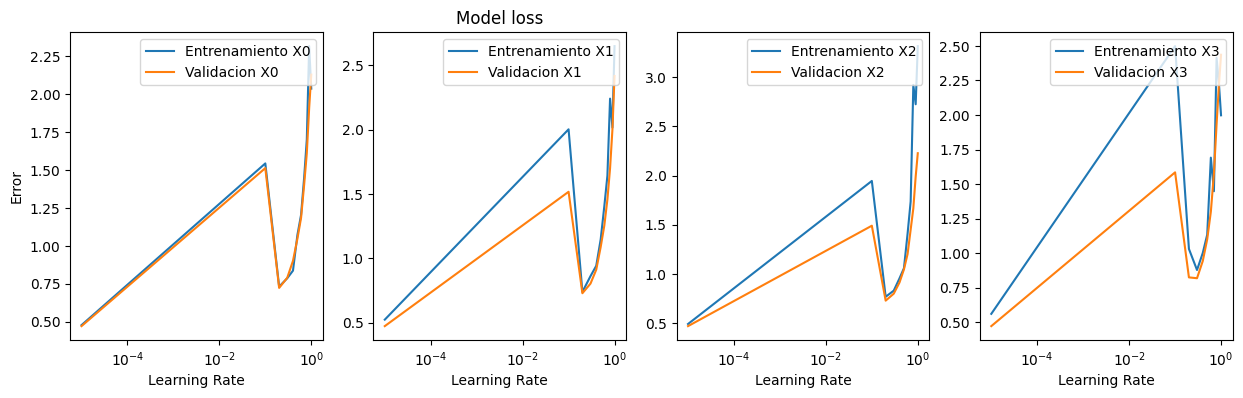

In [69]:
aux1 = [minLoss0_1,minLoss1_1, minLoss2_1, minLoss3_1]
aux2 = [minTrain0_1,minTrain1_1, minTrain2_1, minTrain3_1]
aux3 = ["X0","X1", "X2", "X3"]
fig, ax = plt.subplots(1, 4, figsize=(15,4),)

for i in range(len(aux1)):
    ax[i].plot(RegVal, aux1[i])
    ax[i].plot(RegVal, aux2[i])
    #ax[i].xticks(default_x_ticks, neuronas)
    ax[i].legend(['Entrenamiento ' +aux3[i] ,'Validacion '+aux3[i]], loc='upper right')
    #ax[i].set_ylim(0.4,0.6)
    ax[i].set_xscale("log")
    ax[i].set_xlabel('Valor de regularizacion')

ax[1].set_title('Model loss')
ax[0].set_ylabel('Error')
plt.show()

En todos los dataset se puede observar como al ir aumentando el learning rate el redimiento de la red se vuelve peor. los mejores resultados se obtienen para valores de learning rate bajos

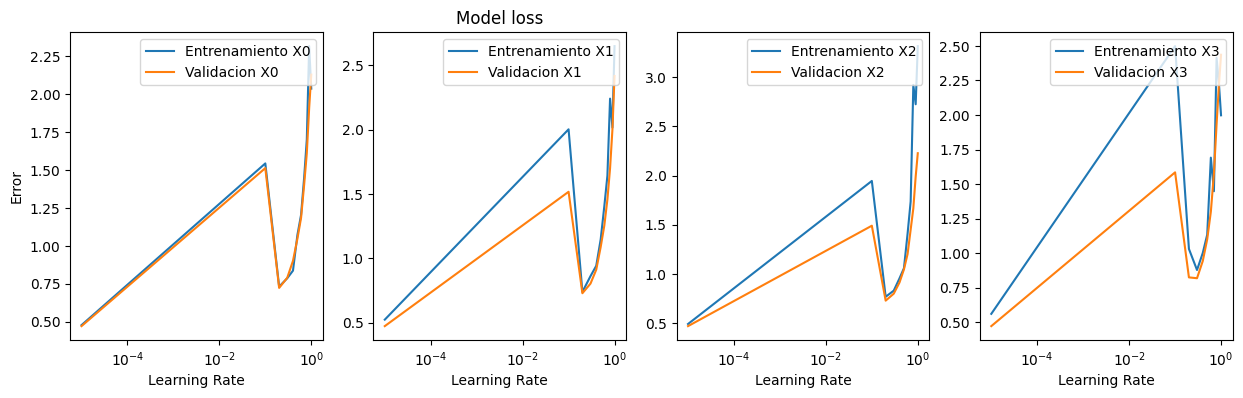

In [70]:
aux1 = [minLoss0_1,minLoss1_1, minLoss2_1, minLoss3_1]
aux2 = [minTrain0_1,minTrain1_1, minTrain2_1, minTrain3_1]
aux3 = ["X0","X1", "X2", "X3"]
fig, ax = plt.subplots(1, 4, figsize=(15,4),)

for i in range(len(aux1)):
    ax[i].plot(RegVal, aux1[i])
    ax[i].plot(RegVal, aux2[i])
    #ax[i].xticks(default_x_ticks, neuronas)
    ax[i].legend(['Entrenamiento ' +aux3[i] ,'Validacion '+aux3[i]], loc='upper right')
    #ax[i].set_ylim(0.4,0.6)
    ax[i].set_xscale("log")
    ax[i].set_xlabel('Valor de regularizacion')

ax[1].set_title('Model loss')
ax[0].set_ylabel('Error')
plt.show()

Para el segundo regularizador, el comportamiento es similar al del regularizador 1, para valores altos, se observa un mal desempeño de la red, mientras que para valores pequeños se observan los mejores rendimientos en todos los datasets

In [71]:
regul= RegVal[0]
regul

1e-05

Los gráficos describen el cambio del error al modificar el regularizador para los distintos dataset. Se puede observar que el menor valor para los errores ocurren en el valor inicial de prueba del regularizador el cual corresponde a 1e-05


### Capa de salida

#### Dataset 0

In [72]:
print("\t Capa Salida L1")
model_reg = Salida1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))
print("\t Capa Salida L2")
model_reg = Salida1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

	 Capa Salida L1
Epoch 1/20
17/17 [==============================] - 1s 21ms/step - loss: 0.6860 - val_loss: 0.6741
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6389 - val_loss: 0.6378
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6057 - val_loss: 0.6108
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5814 - val_loss: 0.5898
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5628 - val_loss: 0.5729
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5481 - val_loss: 0.5591
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5363 - val_loss: 0.5477
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5267 - val_loss: 0.5378
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5187 - val_loss: 0.5291
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5119 - val_loss: 0.5217
E

#### Dataset 1

In [73]:
# Capa salida l1
model_reg = Salida1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))

Epoch 1/20
17/17 [==============================] - 1s 17ms/step - loss: 0.6912 - val_loss: 0.6962
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6330 - val_loss: 0.6539
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5940 - val_loss: 0.6253
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5668 - val_loss: 0.6050
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5468 - val_loss: 0.5899
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5317 - val_loss: 0.5786
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5199 - val_loss: 0.5690
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5108 - val_loss: 0.5615
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5032 - val_loss: 0.5551
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4969 - val_loss: 0.5494
Epoch 11/20
17/17 

In [74]:
# Capa salida l2
model_reg = Salida1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))

Epoch 1/20
17/17 [==============================] - 1s 17ms/step - loss: 0.6557 - val_loss: 0.6763
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6098 - val_loss: 0.6491
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5792 - val_loss: 0.6308
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5576 - val_loss: 0.6173
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5409 - val_loss: 0.6065
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5284 - val_loss: 0.5972
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5183 - val_loss: 0.5891
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5103 - val_loss: 0.5818
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5036 - val_loss: 0.5751
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4978 - val_loss: 0.5689
Epoch 11/20
17/17 

#### Dataset 2

In [75]:
print("\t Capa Salida L1")
model_reg = Salida1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))
print("\t Capa Salida L2")
model_reg = Salida1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))

	 Capa Salida L1
Epoch 1/20
17/17 [==============================] - 1s 23ms/step - loss: 0.6869 - val_loss: 0.6440
Epoch 2/20
17/17 [==============================] - 0s 8ms/step - loss: 0.6236 - val_loss: 0.5946
Epoch 3/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5827 - val_loss: 0.5656
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5559 - val_loss: 0.5474
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5367 - val_loss: 0.5353
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5228 - val_loss: 0.5271
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5121 - val_loss: 0.5207
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5037 - val_loss: 0.5159
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4971 - val_loss: 0.5121
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4916 - val_loss: 0.5089
E

#### Dataset 3

In [76]:
print("\t Capa Salida L1")
model_reg = Salida1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
print("\t Capa Salida L2")
model_reg = Salida1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))

	 Capa Salida L1
Epoch 1/20
17/17 [==============================] - 1s 19ms/step - loss: 0.6754 - val_loss: 0.6437
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6066 - val_loss: 0.6113
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5670 - val_loss: 0.5948
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5423 - val_loss: 0.5859
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5258 - val_loss: 0.5805
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5143 - val_loss: 0.5771
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5056 - val_loss: 0.5743
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4990 - val_loss: 0.5719
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4939 - val_loss: 0.5699
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4895 - val_loss: 0.5683
E

### Ambas capas

#### Dataset X0

In [77]:
print("\t Ambas capas L1")
model_reg = Ambas1(learning_r,'tanh',regul)

history = model_reg.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

print("\t Ambas capas L2")
model_reg = Ambas2(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

	 Ambas capas L1
Epoch 1/20
17/17 [==============================] - 1s 22ms/step - loss: 0.6790 - val_loss: 0.6583
Epoch 2/20
17/17 [==============================] - 0s 12ms/step - loss: 0.6332 - val_loss: 0.6240
Epoch 3/20
17/17 [==============================] - 0s 12ms/step - loss: 0.6010 - val_loss: 0.5984
Epoch 4/20
17/17 [==============================] - 0s 9ms/step - loss: 0.5763 - val_loss: 0.5785
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5580 - val_loss: 0.5626
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5436 - val_loss: 0.5494
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5318 - val_loss: 0.5386
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5222 - val_loss: 0.5294
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5143 - val_loss: 0.5216
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5077 - val_loss: 0.5146

#### Dataset X1

In [78]:
# Ambas capas l1
model_reg = Ambas1(learning_r,'tanh',regul)

history = model_reg.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))

Epoch 1/20
17/17 [==============================] - 1s 17ms/step - loss: 0.6665 - val_loss: 0.6499
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6164 - val_loss: 0.6244
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5828 - val_loss: 0.6081
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5597 - val_loss: 0.5968
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5428 - val_loss: 0.5884
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5297 - val_loss: 0.5815
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5194 - val_loss: 0.5754
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5112 - val_loss: 0.5701
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5046 - val_loss: 0.5651
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4988 - val_loss: 0.5598
Epoch 11/20
17/17 

In [79]:
# Ambas capas l2
model_reg = Ambas2(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))

Epoch 1/20
17/17 [==============================] - 1s 17ms/step - loss: 0.6726 - val_loss: 0.6593
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6211 - val_loss: 0.6332
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5870 - val_loss: 0.6166
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5630 - val_loss: 0.6053
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5459 - val_loss: 0.5970
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5324 - val_loss: 0.5897
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5222 - val_loss: 0.5829
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5137 - val_loss: 0.5767
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5068 - val_loss: 0.5717
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5007 - val_loss: 0.5670
Epoch 11/20
17/17 

#### Dataset X2

In [80]:
print("\t Ambas capas L1")
model_reg = Ambas1(learning_r,'tanh',regul)

history = model_reg.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))

print("\t Ambas capas L2")
model_reg = Ambas2(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))

	 Ambas capas L1
Epoch 1/20
17/17 [==============================] - 1s 18ms/step - loss: 0.6290 - val_loss: 0.6347
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5907 - val_loss: 0.6028
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5640 - val_loss: 0.5809
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5448 - val_loss: 0.5652
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5302 - val_loss: 0.5535
Epoch 6/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5189 - val_loss: 0.5445
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5100 - val_loss: 0.5371
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5027 - val_loss: 0.5314
Epoch 9/20
17/17 [==============================] - 0s 8ms/step - loss: 0.4966 - val_loss: 0.5263
Epoch 10/20
17/17 [==============================] - 0s 7ms/step - loss: 0.4914 - val_loss: 0.5221
E

#### Dataset X3

In [81]:
print("\t Ambas capas L1")
model_reg = Ambas1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))

print("\t Ambas capas L2")
model_reg = Ambas2(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))

	 Ambas capas L1
Epoch 1/20
17/17 [==============================] - 1s 18ms/step - loss: 0.7329 - val_loss: 0.6872
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6371 - val_loss: 0.6392
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5845 - val_loss: 0.6166
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5535 - val_loss: 0.6046
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5338 - val_loss: 0.5974
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5200 - val_loss: 0.5925
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5098 - val_loss: 0.5884
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5020 - val_loss: 0.5848
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4961 - val_loss: 0.5820
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4910 - val_loss: 0.5791
E

## 1.g Exploración del Número de neuronas

Ahora probaremos cambiando el número de neuronas en la capa oculta. Para esto, entrene la red con los hiperparámetros que estimen conveniente luego de la pregunta anterior, variando el numero de neuronas. Deben explorar a lo menos 10 número de neuronas distintos. Una recomendación sería por ejemplo explorar numero de neuronas en potencias de 2. 

Para cada red entrenada, recuperen el mejor error de validación y el error de entrenamiento en la _epoch_ donde se obtuvo tal error de validación. Grafique como se comportan ambos errores a medida crece el número de neuronas y comente. 

In [82]:
def modelo(n,lr,activation):
    model=Sequential()
    model.add(Dense(units = n, activation = activation))
    model.add(Dense(units = 1, activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

### Dataset X0

In [83]:
train_erroro, val_erroro, neuronas = [], [],[]
k=1
for n_units in [2**(k), 2**(k+1), 2**(k+2), 2**(k+3),2**(k+4),2**(k+5),2**(k+6),2**(k+7),2**(k+8), 2**(k+9)]:
    model = modelo(n_units,learning_r,'tanh')
    history = model.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))
    val_e = min(history.history['val_loss'])
    train_e = history.history['loss'][np.argmin(history.history['val_loss'])] 
    val_erroro.append(val_e)
    train_erroro.append(train_e)
    neuronas.append(n_units)

Epoch 1/20
17/17 [==============================] - 1s 19ms/step - loss: 0.6973 - val_loss: 0.6904
Epoch 2/20
17/17 [==============================] - 0s 9ms/step - loss: 0.6933 - val_loss: 0.6873
Epoch 3/20
17/17 [==============================] - 0s 8ms/step - loss: 0.6895 - val_loss: 0.6845
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6861 - val_loss: 0.6819
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6829 - val_loss: 0.6795
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6799 - val_loss: 0.6773
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6772 - val_loss: 0.6754
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6746 - val_loss: 0.6736
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6723 - val_loss: 0.6719
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6702 - val_loss: 0.6705
Epoch 11/20
17/17 

### Dataset X1

In [84]:
train_error1, val_error1, neuronas = [], [],[]
k=1

for n_units in [2**(k), 2**(k+1), 2**(k+2), 2**(k+3),2**(k+4),2**(k+5),2**(k+6),2**(k+7),2**(k+8), 2**(k+9)]:
    model = modelo(n_units,learning_r,'tanh')
    history = model.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))
    val_e = min(history.history['val_loss'])
    train_e = history.history['loss'][np.argmin(history.history['val_loss'])] 
    val_error1.append(val_e)
    train_error1.append(train_e)
    neuronas.append(n_units)

Epoch 1/20
17/17 [==============================] - 1s 18ms/step - loss: 0.7873 - val_loss: 0.7597
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7709 - val_loss: 0.7449
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.7556 - val_loss: 0.7316
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7415 - val_loss: 0.7195
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7285 - val_loss: 0.7084
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7162 - val_loss: 0.6984
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.7048 - val_loss: 0.6894
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6943 - val_loss: 0.6812
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6844 - val_loss: 0.6739
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6752 - val_loss: 0.6673
Epoch 11/20
17/17 

### Dataset X2

In [85]:
train_error2, val_error2, neuronas = [], [],[]
k=1
for n_units in [2**(k), 2**(k+1), 2**(k+2), 2**(k+3),2**(k+4),2**(k+5),2**(k+6),2**(k+7),2**(k+8), 2**(k+9)]:
    model = modelo(n_units,learning_r,'tanh')
    history = model.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))
    val_e = min(history.history['val_loss'])
    train_e = history.history['loss'][np.argmin(history.history['val_loss'])] 
    val_error2.append(val_e)
    train_error2.append(train_e)
    neuronas.append(n_units)

Epoch 1/20
17/17 [==============================] - 1s 19ms/step - loss: 0.6960 - val_loss: 0.7589
Epoch 2/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6843 - val_loss: 0.7537
Epoch 3/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6740 - val_loss: 0.7491
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6647 - val_loss: 0.7450
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6560 - val_loss: 0.7413
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6480 - val_loss: 0.7380
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6408 - val_loss: 0.7351
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6341 - val_loss: 0.7324
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6279 - val_loss: 0.7299
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6222 - val_loss: 0.7277
Epoch 11/20
17/17 

### Dataset X3

In [86]:
train_error3, val_error3, neuronas = [], [],[]
k=1
for n_units in [2**(k), 2**(k+1), 2**(k+2), 2**(k+3),2**(k+4),2**(k+5),2**(k+6),2**(k+7),2**(k+8), 2**(k+9)]:
    model = modelo(n_units,learning_r,'tanh')
    history = model.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
    val_e = min(history.history['val_loss'])
    train_e = history.history['loss'][np.argmin(history.history['val_loss'])] 
    val_error3.append(val_e)
    train_error3.append(train_e)
    neuronas.append(n_units)

Epoch 1/20
17/17 [==============================] - 1s 49ms/step - loss: 0.6687 - val_loss: 0.7057
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6556 - val_loss: 0.6974
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6440 - val_loss: 0.6901
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6333 - val_loss: 0.6838
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6236 - val_loss: 0.6782
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6148 - val_loss: 0.6733
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6067 - val_loss: 0.6690
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5992 - val_loss: 0.6653
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5925 - val_loss: 0.6620
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5862 - val_loss: 0.6590
Epoch 11/20
17/17 

### Graficos comparativos

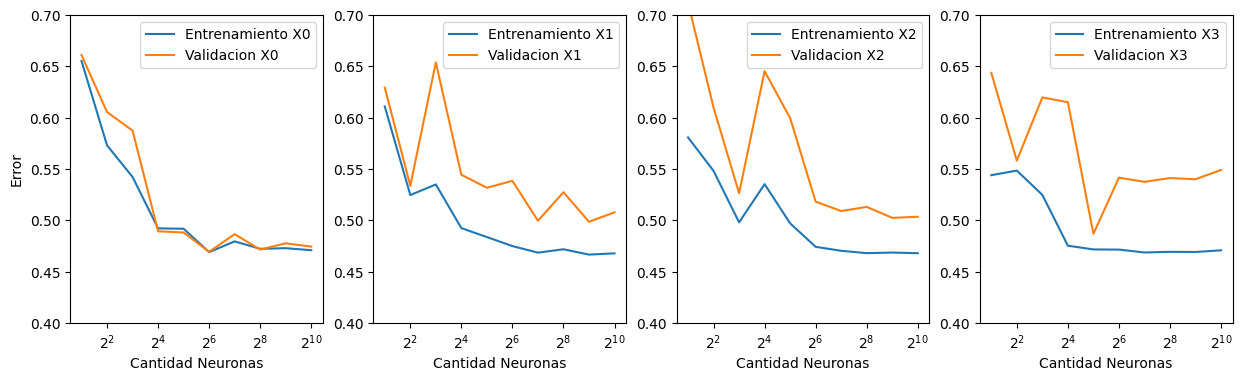

In [87]:
#default_x_ticks = range(len(neuronas))
default_x_ticks =  [2**(k), 2**(k+1), 2**(k+2), 2**(k+3),2**(k+4),2**(k+5),2**(k+6),2**(k+7),2**(k+8), 2**(k+9)]
aux1 = [train_erroro,train_error1, train_error2, train_error3]
aux2 = [val_erroro,val_error1, val_error2, val_error3]
aux3 = ["X0","X1", "X2", "X3"]
fig, ax = plt.subplots(1, 4, figsize=(15,4),)

for i in range(len(aux1)):
    ax[i].plot(default_x_ticks, aux1[i])
    ax[i].plot(default_x_ticks, aux2[i])
    ax[i].legend(['Entrenamiento ' +aux3[i] ,'Validacion '+aux3[i]], loc='upper right')
    ax[i].set_ylim(0.4,0.7)
    ax[i].set_xlabel('Cantidad Neuronas')
    ax[i].set_xscale("log", base=2)

ax[0].set_ylabel('Error')
plt.show()

En las graficas se puede observar como al ir aumentando el numero de neuronas aparece una tendencia a converger, el problema es que los graficos no son concluyentes debido al bajo numero de epoch con las que se entreno la red, ya que para valores mas altos de neuronas, seria apropiado el aumentar el numero de epochs.

Independiente de eso, se observa un mejor rendimiento en el dataset $X_0$

## 1.h Dropout
Como seguramente constataron en la pregunta anterior, un numero demasiado grande de parámetros en el modelo puede llevarnos a observar el fenomeno de _overfitting_. Una aproximación a este fenómeno que ha dado excelente resultado en redes neuronales es el método _dropout_, donde estocásticamente se desactivan una fracción de las neuronas al momento del entrenamiento, así efectivamente reduciendo el tamaño del modelo que se entrena en cada iteración e implicitamente obteniendo modelos más robustos por el simple hecho que al momento de entrenar nunca se entrena el "mismo" modelo. 

Según lo aprendido en el ramo, ¿en qué consiste el fenómeno de _overfitting_? ¿Por qué modelos más grandes suelen presentar el fenómeno? 

Entrene la mejor red obtenida en la pregunta anterior agregando una capa de _Dropout_ con parámetro $0.5$ inmediatamente luego de la capa oculta. Repita luego el proceso con una red con el doble de neuronas. Note que el agregar una capa _dropout_ hará que la red entrene más lento, por lo cual es recomendable aumentar el numero de _epochs_ para entrenar la red a completitud. 

¿Qué observa al agregar _dropout_? Comente y compare con sus resultados anteriores. 

In [88]:
def Drop(n,lr,activation):
    model=Sequential()
    model.add(Dense(units = n, activation = activation))
    model.add(Dropout(0.5))
    model.add(Dense(units = 1,activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

### Dataset X0

In [89]:
modelo_1 = Drop(256,learning_r,'tanh')
    
historyo_1 = modelo_1.fit(x_tr_o, y_tr, epochs=50, validation_data=(x_val_o,y_val))

Epoch 1/50
17/17 [==============================] - 1s 18ms/step - loss: 0.7150 - val_loss: 0.6723
Epoch 2/50
17/17 [==============================] - 0s 6ms/step - loss: 0.6518 - val_loss: 0.6317
Epoch 3/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5894 - val_loss: 0.6022
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5805 - val_loss: 0.5808
Epoch 5/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5571 - val_loss: 0.5642
Epoch 6/50
17/17 [==============================] - 0s 8ms/step - loss: 0.5487 - val_loss: 0.5505
Epoch 7/50
17/17 [==============================] - 0s 8ms/step - loss: 0.5365 - val_loss: 0.5392
Epoch 8/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5231 - val_loss: 0.5307
Epoch 9/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5146 - val_loss: 0.5234
Epoch 10/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5159 - val_loss: 0.5165
Epoch 11/50
17/17 

In [90]:
modelo_2 = Drop(256*2,learning_r,'tanh')
    
historyo_2 = modelo_2.fit(x_tr_1, y_tr, epochs=50, validation_data=(x_val_1,y_val))

Epoch 1/50
17/17 [==============================] - 1s 19ms/step - loss: 0.6808 - val_loss: 0.6517
Epoch 2/50
17/17 [==============================] - 0s 8ms/step - loss: 0.6235 - val_loss: 0.6136
Epoch 3/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5881 - val_loss: 0.5913
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5562 - val_loss: 0.5770
Epoch 5/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5419 - val_loss: 0.5662
Epoch 6/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5300 - val_loss: 0.5584
Epoch 7/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5178 - val_loss: 0.5526
Epoch 8/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5095 - val_loss: 0.5459
Epoch 9/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5026 - val_loss: 0.5402
Epoch 10/50
17/17 [==============================] - 0s 8ms/step - loss: 0.4941 - val_loss: 0.5361
Epoch 11/50
17/17 

### Dataset X1

In [91]:
model1_1 = Drop(256,learning_r,'tanh')
    
history1_1 = model1_1.fit(x_tr_1, y_tr, epochs=50, validation_data=(x_val_1,y_val))

Epoch 1/50
17/17 [==============================] - 1s 19ms/step - loss: 0.7731 - val_loss: 0.7289
Epoch 2/50
17/17 [==============================] - 0s 6ms/step - loss: 0.6948 - val_loss: 0.6550
Epoch 3/50
17/17 [==============================] - 0s 6ms/step - loss: 0.6415 - val_loss: 0.6136
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5979 - val_loss: 0.5900
Epoch 5/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5666 - val_loss: 0.5752
Epoch 6/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5496 - val_loss: 0.5656
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5353 - val_loss: 0.5593
Epoch 8/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5227 - val_loss: 0.5545
Epoch 9/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5165 - val_loss: 0.5504
Epoch 10/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5192 - val_loss: 0.5470
Epoch 11/50
17/17 

In [92]:
model1_2 = Drop(256*2,learning_r,'tanh')
    
history1_2 = model1_2.fit(x_tr_1, y_tr, epochs=50, validation_data=(x_val_1,y_val))

Epoch 1/50
17/17 [==============================] - 1s 20ms/step - loss: 0.7071 - val_loss: 0.6760
Epoch 2/50
17/17 [==============================] - 0s 7ms/step - loss: 0.6457 - val_loss: 0.6375
Epoch 3/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5960 - val_loss: 0.6159
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5674 - val_loss: 0.6016
Epoch 5/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5467 - val_loss: 0.5911
Epoch 6/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5355 - val_loss: 0.5834
Epoch 7/50
17/17 [==============================] - 0s 8ms/step - loss: 0.5238 - val_loss: 0.5767
Epoch 8/50
17/17 [==============================] - 0s 8ms/step - loss: 0.5218 - val_loss: 0.5704
Epoch 9/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5011 - val_loss: 0.5652
Epoch 10/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5044 - val_loss: 0.5604
Epoch 11/50
17/17 

### Dataset X2

In [93]:
model2_1 = Drop(256,learning_r,'tanh')
    
history2_1 = model2_1.fit(x_tr_2, y_tr, epochs=50, validation_data=(x_val_2,y_val))

Epoch 1/50
17/17 [==============================] - 1s 16ms/step - loss: 0.6641 - val_loss: 0.6215
Epoch 2/50
17/17 [==============================] - 0s 6ms/step - loss: 0.6085 - val_loss: 0.5900
Epoch 3/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5691 - val_loss: 0.5722
Epoch 4/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5559 - val_loss: 0.5609
Epoch 5/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5416 - val_loss: 0.5527
Epoch 6/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5272 - val_loss: 0.5458
Epoch 7/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5209 - val_loss: 0.5405
Epoch 8/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5121 - val_loss: 0.5364
Epoch 9/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5044 - val_loss: 0.5316
Epoch 10/50
17/17 [==============================] - 0s 6ms/step - loss: 0.4960 - val_loss: 0.5280
Epoch 11/50
17/17 

In [94]:
model2_2 = Drop(256*2,learning_r,'tanh')
    
history2_2 = model2_2.fit(x_tr_2, y_tr, epochs=50, validation_data=(x_val_2,y_val))

Epoch 1/50
17/17 [==============================] - 1s 18ms/step - loss: 0.6548 - val_loss: 0.6451
Epoch 2/50
17/17 [==============================] - 0s 6ms/step - loss: 0.6096 - val_loss: 0.6157
Epoch 3/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5789 - val_loss: 0.5969
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5569 - val_loss: 0.5836
Epoch 5/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5421 - val_loss: 0.5728
Epoch 6/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5282 - val_loss: 0.5642
Epoch 7/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5146 - val_loss: 0.5573
Epoch 8/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5062 - val_loss: 0.5515
Epoch 9/50
17/17 [==============================] - 0s 8ms/step - loss: 0.5001 - val_loss: 0.5464
Epoch 10/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5024 - val_loss: 0.5413
Epoch 11/50
17/17 

### Dataset X3

In [95]:
model3_1 = Drop(256,learning_r,'tanh')
    
history3_1 = model3_1.fit(x_tr_3, y_tr, epochs=50, validation_data=(x_val_3,y_val))

Epoch 1/50
17/17 [==============================] - 1s 19ms/step - loss: 0.6662 - val_loss: 0.6615
Epoch 2/50
17/17 [==============================] - 0s 7ms/step - loss: 0.6165 - val_loss: 0.6344
Epoch 3/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5685 - val_loss: 0.6208
Epoch 4/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5519 - val_loss: 0.6131
Epoch 5/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5450 - val_loss: 0.6066
Epoch 6/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5278 - val_loss: 0.6030
Epoch 7/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5128 - val_loss: 0.5987
Epoch 8/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5145 - val_loss: 0.5942
Epoch 9/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5054 - val_loss: 0.5911
Epoch 10/50
17/17 [==============================] - 0s 6ms/step - loss: 0.4943 - val_loss: 0.5873
Epoch 11/50
17/17 

In [96]:
model3_2 = Drop(256*2,learning_r,'tanh')
    
history3_2 = model3_2.fit(x_tr_3, y_tr, epochs=50, validation_data=(x_val_3,y_val))

Epoch 1/50
17/17 [==============================] - 1s 36ms/step - loss: 0.7066 - val_loss: 0.6422
Epoch 2/50
17/17 [==============================] - 0s 6ms/step - loss: 0.6285 - val_loss: 0.6027
Epoch 3/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5745 - val_loss: 0.5868
Epoch 4/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5523 - val_loss: 0.5802
Epoch 5/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5227 - val_loss: 0.5776
Epoch 6/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5134 - val_loss: 0.5751
Epoch 7/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5109 - val_loss: 0.5742
Epoch 8/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5101 - val_loss: 0.5727
Epoch 9/50
17/17 [==============================] - 0s 5ms/step - loss: 0.4928 - val_loss: 0.5713
Epoch 10/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5003 - val_loss: 0.5704
Epoch 11/50
17/17 

### Graficos comparativos

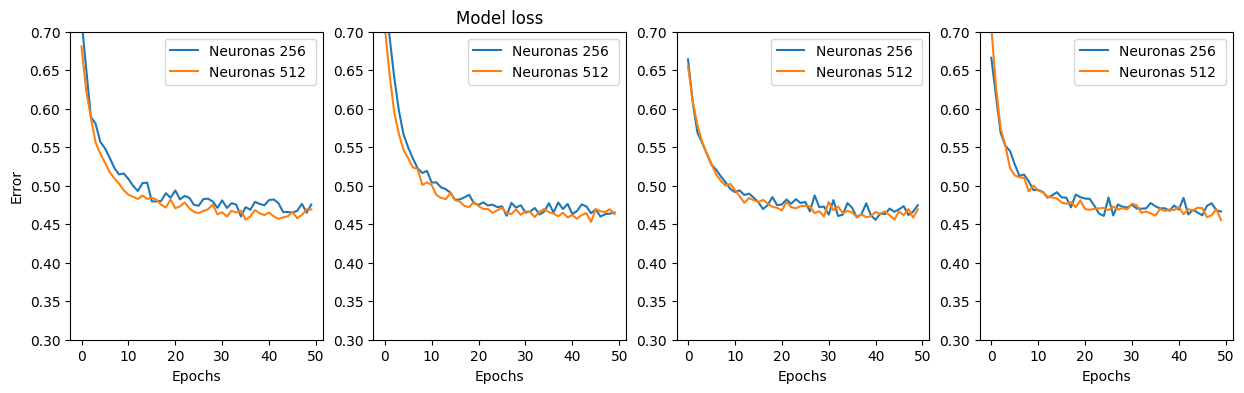

In [97]:
default_x_ticks = range(50)

fig, ax = plt.subplots(1, 4, figsize=(15,4),)

ax[0].set_ylim(0.3,0.7)
ax[1].set_ylim(0.3,0.7)
ax[2].set_ylim(0.3,0.7)
ax[3].set_ylim(0.3,0.7)
ax[0].plot(default_x_ticks, historyo_1.history['loss'])
ax[1].plot(default_x_ticks, history1_1.history['loss'])
ax[2].plot(default_x_ticks, history2_1.history['loss'])
ax[3].plot(default_x_ticks, history3_1.history['loss'])

ax[0].plot(default_x_ticks, historyo_2.history['loss'])
ax[1].plot(default_x_ticks, history1_2.history['loss'])
ax[2].plot(default_x_ticks, history2_2.history['loss'])
ax[3].plot(default_x_ticks, history3_2.history['loss'])

ax[1].set_title('Model loss')
ax[0].set_ylabel('Error')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[2].set_xlabel('Epochs')
ax[3].set_xlabel('Epochs')

ax[0].legend(['Neuronas 256' ,'Neuronas 512 '], loc='upper right')
ax[1].legend(['Neuronas 256' ,'Neuronas 512 '], loc='upper right')
ax[2].legend(['Neuronas 256' ,'Neuronas 512 '], loc='upper right')
ax[3].legend(['Neuronas 256' ,'Neuronas 512 '], loc='upper right')


plt.show()

### Respuestas

El overfitting es un fenomeno en que la red aprende muy bien el conjunto de datos pero al momento de usar datos nuevos la prediccion es muy mala.

Un fenomeno que se puede observar en comparacion a los graficos anteriores es que las curvas entre la prediccion de entrenamiento y la de validacion son similares (el gap entre ellas es pequeño), lo que quiere decir que el modelo esta "prediciendo correctamente", por otro lado, vemos una tendencia en la reduccion del error.

## 1.i Learning Rate Decay
Ahora entrenaremos un modelo manejando manualmente el _learn rate_. Para esto utilizaremos el _callback_ `LearningRateScheduler`. Este _callback_ nos permitirá implementar una función que maneje el _learn rate_ de nuestro modelo. 

Escriba una función que reciba la epoca actual y retorne un _learn rate_ lr. El lr inicial debe ser igual o mayor a alguno que haya dado buenos resultados en las preguntas anteriores. La función debe dividir por 2 el lr cada 10 _epochs_. Además ponga como restricción que el lr no debe ser menor a $5\times 10^{-5}$, es decir si el valor obtenido es menor a  $5\times 10^{-5}$, la función retorna  $5\times 10^{-5}$.

Entrene su red preferida de las preguntas anteriores con esta modificación, grafique los errores a lo largo del entrenamiento y comente. Según lo visto en el ramo, ¿por qué podría ser util disminuir el _learn rate_ a medida se avanza en el aprendizaje de la red?

In [98]:
def step_decay(epoch,lr):
    if epoch%10==0:
        lr=lr/2
    if lr<= 5*(10**(-5)):
        lr= 5*(10**(-5))
    return lr

### Dataset X0

In [99]:
schedule1 = LearningRateScheduler(step_decay)
modelo = Drop(256,learning_r,'tanh')
historyo = modelo.fit(x_tr_o, y_tr, epochs=60, validation_data=(x_val_o,y_val),callbacks=[schedule1])

Epoch 1/60
17/17 [==============================] - 1s 19ms/step - loss: 0.7238 - val_loss: 0.6906 - lr: 0.0045
Epoch 2/60
17/17 [==============================] - 0s 6ms/step - loss: 0.6998 - val_loss: 0.6599 - lr: 0.0045
Epoch 3/60
17/17 [==============================] - 0s 7ms/step - loss: 0.6794 - val_loss: 0.6355 - lr: 0.0045
Epoch 4/60
17/17 [==============================] - 0s 6ms/step - loss: 0.6600 - val_loss: 0.6149 - lr: 0.0045
Epoch 5/60
17/17 [==============================] - 0s 6ms/step - loss: 0.6148 - val_loss: 0.5985 - lr: 0.0045
Epoch 6/60
17/17 [==============================] - 0s 6ms/step - loss: 0.6102 - val_loss: 0.5839 - lr: 0.0045
Epoch 7/60
17/17 [==============================] - 0s 5ms/step - loss: 0.5983 - val_loss: 0.5724 - lr: 0.0045
Epoch 8/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5806 - val_loss: 0.5621 - lr: 0.0045
Epoch 9/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5812 - val_loss: 0.5532 - lr: 0.0045


### Dataset X1

In [100]:
schedule1 = LearningRateScheduler(step_decay)
model1 = Drop(256,learning_r,'tanh')
history1 = model1.fit(x_tr_1, y_tr, epochs=60, validation_data=(x_val_1,y_val),callbacks=[schedule1])

Epoch 1/60
17/17 [==============================] - 1s 15ms/step - loss: 0.7106 - val_loss: 0.6862 - lr: 0.0045
Epoch 2/60
17/17 [==============================] - 0s 6ms/step - loss: 0.6704 - val_loss: 0.6617 - lr: 0.0045
Epoch 3/60
17/17 [==============================] - 0s 6ms/step - loss: 0.6502 - val_loss: 0.6434 - lr: 0.0045
Epoch 4/60
17/17 [==============================] - 0s 6ms/step - loss: 0.6328 - val_loss: 0.6291 - lr: 0.0045
Epoch 5/60
17/17 [==============================] - 0s 5ms/step - loss: 0.6080 - val_loss: 0.6183 - lr: 0.0045
Epoch 6/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5906 - val_loss: 0.6087 - lr: 0.0045
Epoch 7/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5709 - val_loss: 0.6011 - lr: 0.0045
Epoch 8/60
17/17 [==============================] - 0s 5ms/step - loss: 0.5614 - val_loss: 0.5956 - lr: 0.0045
Epoch 9/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5600 - val_loss: 0.5907 - lr: 0.0045


### Dataset X2

In [101]:
schedule2 = LearningRateScheduler(step_decay)
model2 = Drop(256,learning_r,'tanh')
history2 = model2.fit(x_tr_2, y_tr, epochs=60, validation_data=(x_val_2,y_val),callbacks=[schedule2])

Epoch 1/60
17/17 [==============================] - 1s 19ms/step - loss: 0.7512 - val_loss: 0.7132 - lr: 0.0045
Epoch 2/60
17/17 [==============================] - 0s 5ms/step - loss: 0.7065 - val_loss: 0.6706 - lr: 0.0045
Epoch 3/60
17/17 [==============================] - 0s 5ms/step - loss: 0.6628 - val_loss: 0.6388 - lr: 0.0045
Epoch 4/60
17/17 [==============================] - 0s 6ms/step - loss: 0.6392 - val_loss: 0.6154 - lr: 0.0045
Epoch 5/60
17/17 [==============================] - 0s 7ms/step - loss: 0.6091 - val_loss: 0.5973 - lr: 0.0045
Epoch 6/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5999 - val_loss: 0.5836 - lr: 0.0045
Epoch 7/60
17/17 [==============================] - 0s 8ms/step - loss: 0.5851 - val_loss: 0.5722 - lr: 0.0045
Epoch 8/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5637 - val_loss: 0.5634 - lr: 0.0045
Epoch 9/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5518 - val_loss: 0.5563 - lr: 0.0045


### Dataset X3

In [102]:
schedule3 = LearningRateScheduler(step_decay)
model3 = Drop(256,learning_r,'tanh')
history3 = model3.fit(x_tr_3, y_tr, epochs=60, validation_data=(x_val_3,y_val),callbacks=[schedule3])

Epoch 1/60
17/17 [==============================] - 1s 19ms/step - loss: 0.6840 - val_loss: 0.6832 - lr: 0.0045
Epoch 2/60
17/17 [==============================] - 0s 6ms/step - loss: 0.6454 - val_loss: 0.6539 - lr: 0.0045
Epoch 3/60
17/17 [==============================] - 0s 7ms/step - loss: 0.6353 - val_loss: 0.6314 - lr: 0.0045
Epoch 4/60
17/17 [==============================] - 0s 7ms/step - loss: 0.5950 - val_loss: 0.6149 - lr: 0.0045
Epoch 5/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5660 - val_loss: 0.6020 - lr: 0.0045
Epoch 6/60
17/17 [==============================] - 0s 7ms/step - loss: 0.5786 - val_loss: 0.5914 - lr: 0.0045
Epoch 7/60
17/17 [==============================] - 0s 7ms/step - loss: 0.5587 - val_loss: 0.5832 - lr: 0.0045
Epoch 8/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5433 - val_loss: 0.5764 - lr: 0.0045
Epoch 9/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5479 - val_loss: 0.5710 - lr: 0.0045


### Graficos comparativos

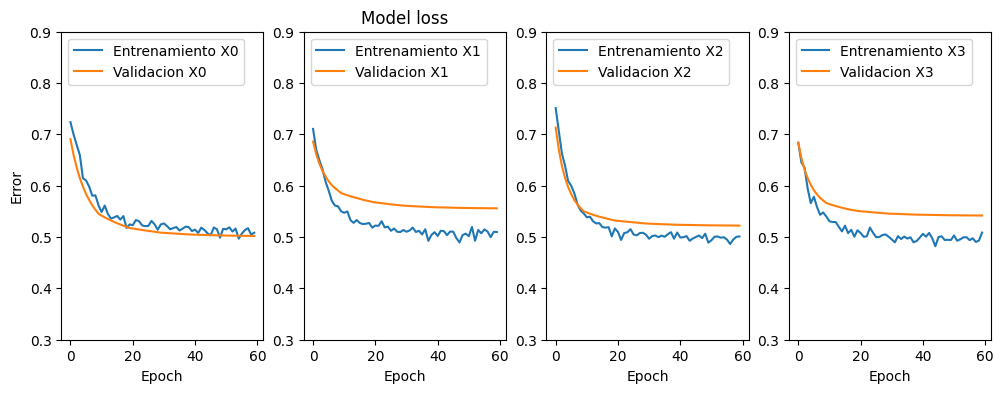

In [103]:
fig, ax = plt.subplots(1, 4, figsize=(12,4),)
aux = [historyo,history1, history2, history3]
aux2 = ["X0","X1", "X2", "X3"]

for i in range(4):
    ax[i].set_ylim(0.3,0.9)
    ax[i].plot(range(60), aux[i].history['loss'])
    ax[i].plot(range(60), aux[i].history['val_loss'])
    ax[0].set_ylabel('Error')
    ax[i].set_xlabel('Epoch')
    ax[i].legend(['Entrenamiento '+aux2[i], 'Validacion '+aux2[i]], loc='upper left')

ax[1].set_title('Model loss')

plt.show()

En la grafica se pueden observar los mejores rendimientos en los conjuntos $X_0$ y $X_2$.

### Respuestas

Disminuir el lerning rate nos ayuda a asegurar una convergencia de la red a un minimo, esto es porque con un valor muy alto, los saltos que realiza la red en busca del minimo son muy grandes y puede saltarse muchos minimos en el camino, por otro lado con un valor muy pequeño, el algoritmo tardara mucho en alcanzar el minimo, por ello es que se utiliza un ajuste del learning rate dinamico, donde a medida que avanzamos en las epocas, disminuimos su valor ya que en cada epoca estaremos cerca del minimo y por lo tanto no sera necesario dar pasos tan grandes.

## 1.j Vanishing Gradient

`Nota:` para esta y las siguientes preguntas solo considere el mejor conjunto de entrenamiento obtenidos a partir de la imputación, es decir, escoja el $X \in \{X_1, X_2, X_3\}$ con el que mejores resultados haya obtenido hasta ahora.

El fenómeno del _vanishing gradient_ es el rápido decaimiento del paso de _Backpropagation_ al avanzar por las capas. A lo largo de la tarea solo hemos entrenado capas con una red oculta, de igual forma que la comunidad cientifica realizo por largo tiempo, por el problema del _vanishing gradient_ y por el teorema de aproximación universal que resumidamente demuestra que una red de una sola capa puede aproximar una amplia familia de funciones. 

En esta pregunta entrenaremos una red neuronal profunda sin implementar ninguno de los dispositivos que permiten hoy en día sortear el problema del _vanishing gradient_, para ponerlo en evidencia. Para esto construya una red con 6 capas ocultas, con la siguiente lista de numero de neuronas: $256$ $256$ $128$ $128$ $32$ y $32$, o con valores similares. De tal manera obtendrá un valor de parámetros relativamente comparable a los valores utilizados en las primeras redes. 

Grafique un histograma con los pesos de las 6 capas densas de la red sin entrenar, entrenela a completitud con el método que estime conveniente y luego grafique nuevamente los histogramas para las 6 capas. Comente lo que observa. 

Luego, pruebe cambiar la inizialización de los pesos de la capa densa, puede revisar la documentación de keras para ver las opciones existentes a parte de `glorot_uniform` por defecto. ¿Se logra solucionar el problema? 

Por último, pruebe aumentar la tasa de aprendizaje para ver si logra hacer que el paso de _backpropagation_ alcance las capas que anteriormente no se entrenaban. ¿Qué observa en este caso? 

In [104]:
def VG(lr, activation, initializer):
    model=Sequential()
    # Hidden Layer
    model.add(Dense(units = 256, activation = activation,kernel_initializer=initializer))
    model.add(Dense(units = 256, activation = activation, kernel_initializer=initializer))
    model.add(Dense(units = 128, activation = activation, kernel_initializer=initializer))
    model.add(Dense(units = 128, activation = activation, kernel_initializer=initializer))
    model.add(Dense(units = 32, activation = activation, kernel_initializer=initializer))
    model.add(Dense(units = 32, activation = activation, kernel_initializer=initializer))
    # Output Layer
    model.add(Dense(units = 1,activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

In [105]:
init = tf.keras.initializers.glorot_uniform()
model=VG(0.02,'tanh', init)

### Gráfico entrenado

In [106]:
history1 = model.fit(x_tr_1, y_tr, epochs=30, validation_data=(x_val_1,y_val))

Epoch 1/30


C:\Users\javin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


17/17 [==============================] - 1s 22ms/step - loss: 0.5842 - val_loss: 0.5776
Epoch 2/30
17/17 [==============================] - 0s 7ms/step - loss: 0.4976 - val_loss: 0.5333
Epoch 3/30
17/17 [==============================] - 0s 7ms/step - loss: 0.4801 - val_loss: 0.5076
Epoch 4/30
17/17 [==============================] - 0s 6ms/step - loss: 0.4714 - val_loss: 0.5100
Epoch 5/30
17/17 [==============================] - 0s 7ms/step - loss: 0.4671 - val_loss: 0.4936
Epoch 6/30
17/17 [==============================] - 0s 7ms/step - loss: 0.4651 - val_loss: 0.4821
Epoch 7/30
17/17 [==============================] - 0s 7ms/step - loss: 0.4625 - val_loss: 0.4734
Epoch 8/30
17/17 [==============================] - 0s 7ms/step - loss: 0.4623 - val_loss: 0.4680
Epoch 9/30
17/17 [==============================] - 0s 7ms/step - loss: 0.4591 - val_loss: 0.4615
Epoch 10/30
17/17 [==============================] - 0s 7ms/step - loss: 0.4607 - val_loss: 0.4638
Epoch 11/30
17/17 [==========

Text(0.5, 1.0, 'Valores finales')

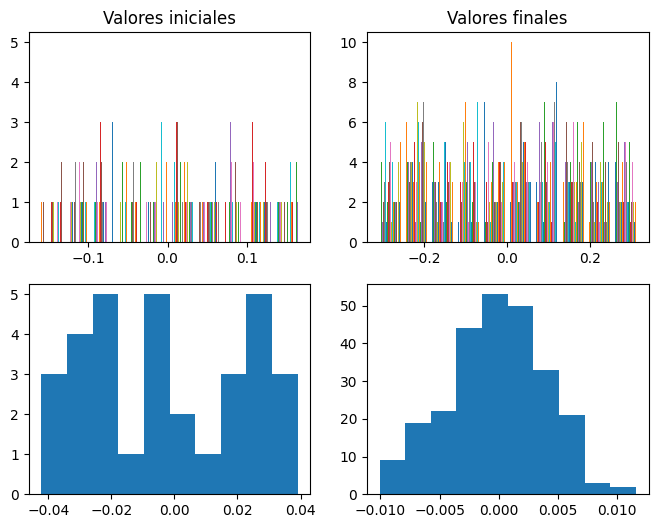

In [107]:
fig, ax = plt.subplots(2, 2, figsize=(8,6),)
ax[0,0].hist(model.get_layer(index=0).get_weights()[0])
ax[1,1].hist(model.get_layer(index=0).get_weights()[1])

ax[0,1].hist(model.get_layer(index=5).get_weights()[0])
ax[1,0].hist(model.get_layer(index=5).get_weights()[1])
ax[0,0].set_title("Valores iniciales")
ax[0,1].set_title("Valores finales")

### Diferentes inializadores

In [108]:
model=VG(learning_r,'tanh', tf.keras.initializers.glorot_uniform())
history1 = model.fit(x_tr_1, y_tr, epochs=30, validation_data=(x_val_1,y_val))

Epoch 1/30
17/17 [==============================] - 2s 30ms/step - loss: 0.6094 - val_loss: 0.5693
Epoch 2/30
17/17 [==============================] - 0s 10ms/step - loss: 0.5261 - val_loss: 0.5414
Epoch 3/30
17/17 [==============================] - 0s 11ms/step - loss: 0.4987 - val_loss: 0.5237
Epoch 4/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4847 - val_loss: 0.5100
Epoch 5/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4763 - val_loss: 0.5032
Epoch 6/30
17/17 [==============================] - 0s 11ms/step - loss: 0.4720 - val_loss: 0.4984
Epoch 7/30
17/17 [==============================] - 0s 11ms/step - loss: 0.4676 - val_loss: 0.4881
Epoch 8/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4656 - val_loss: 0.4815
Epoch 9/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4636 - val_loss: 0.4802
Epoch 10/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4631 - val_loss: 0.4787
Epoch 11/

Text(0.5, 1.0, 'Valores finales')

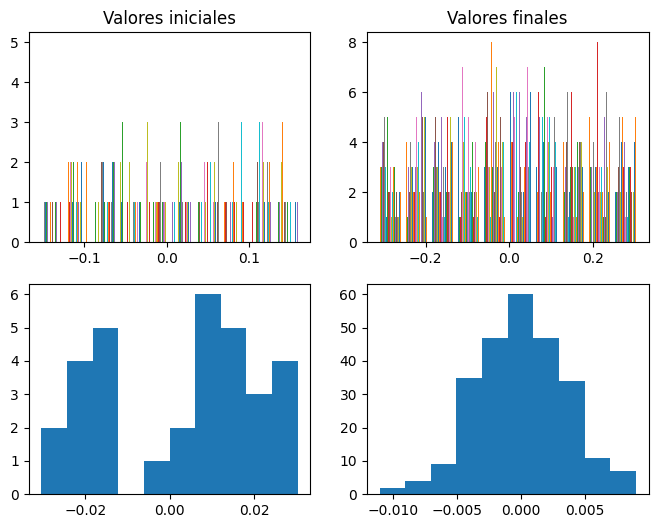

In [109]:
fig, ax = plt.subplots(2, 2, figsize=(8,6),)
ax[0,0].hist(model.get_layer(index=0).get_weights()[0])
ax[1,1].hist(model.get_layer(index=0).get_weights()[1])

ax[0,1].hist(model.get_layer(index=5).get_weights()[0])
ax[1,0].hist(model.get_layer(index=5).get_weights()[1])
ax[0,0].set_title("Valores iniciales")
ax[0,1].set_title("Valores finales")

In [110]:
model=VG(0.02,'tanh',tf.keras.initializers.HeNormal())
history1 = model.fit(x_tr_1, y_tr, epochs=30, validation_data=(x_val_1,y_val))

Epoch 1/30


C:\Users\javin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


17/17 [==============================] - 2s 30ms/step - loss: 0.5718 - val_loss: 0.5562
Epoch 2/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4983 - val_loss: 0.5313
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 0.4689 - val_loss: 0.5236
Epoch 4/30
17/17 [==============================] - 0s 9ms/step - loss: 0.4511 - val_loss: 0.5145
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 0.4322 - val_loss: 0.5163
Epoch 6/30
17/17 [==============================] - 0s 8ms/step - loss: 0.4210 - val_loss: 0.5148
Epoch 7/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4103 - val_loss: 0.5210
Epoch 8/30
17/17 [==============================] - 0s 9ms/step - loss: 0.3992 - val_loss: 0.5185
Epoch 9/30
17/17 [==============================] - 0s 10ms/step - loss: 0.3888 - val_loss: 0.5099
Epoch 10/30
17/17 [==============================] - 0s 9ms/step - loss: 0.3812 - val_loss: 0.5156
Epoch 11/30
17/17 [=======

Text(0.5, 1.0, 'Valores finales')

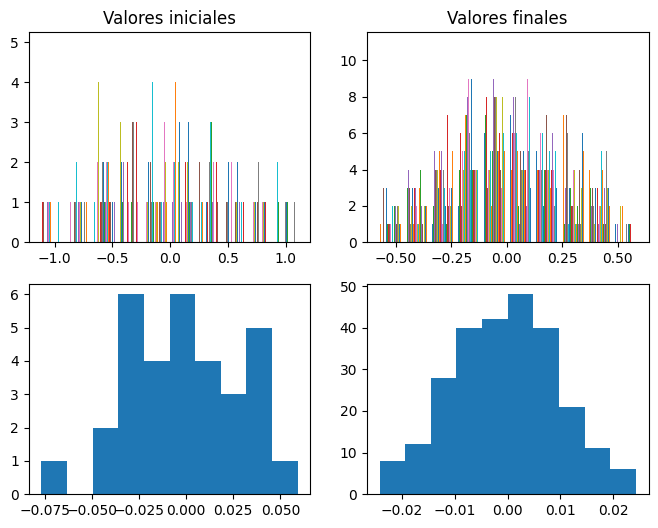

In [111]:
fig, ax = plt.subplots(2, 2, figsize=(8,6),)
ax[0,0].hist(model.get_layer(index=0).get_weights()[0])
ax[1,1].hist(model.get_layer(index=0).get_weights()[1])

ax[0,1].hist(model.get_layer(index=5).get_weights()[0])
ax[1,0].hist(model.get_layer(index=5).get_weights()[1])
ax[0,0].set_title("Valores iniciales")
ax[0,1].set_title("Valores finales")

In [112]:
model=VG(0.02,'tanh', tf.keras.initializers.LecunNormal())
history1 = model.fit(x_tr_1, y_tr, epochs=30, validation_data=(x_val_1,y_val))

Epoch 1/30


C:\Users\javin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer LecunNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


17/17 [==============================] - 2s 29ms/step - loss: 0.5903 - val_loss: 0.5105
Epoch 2/30
17/17 [==============================] - 0s 9ms/step - loss: 0.4908 - val_loss: 0.4957
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 0.4760 - val_loss: 0.4819
Epoch 4/30
17/17 [==============================] - 0s 11ms/step - loss: 0.4664 - val_loss: 0.4676
Epoch 5/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4627 - val_loss: 0.4685
Epoch 6/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4605 - val_loss: 0.4701
Epoch 7/30
17/17 [==============================] - 0s 9ms/step - loss: 0.4561 - val_loss: 0.4620
Epoch 8/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4534 - val_loss: 0.4727
Epoch 9/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4500 - val_loss: 0.4772
Epoch 10/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4505 - val_loss: 0.4659
Epoch 11/30
17/17 [====

Text(0.5, 1.0, 'Valores finales')

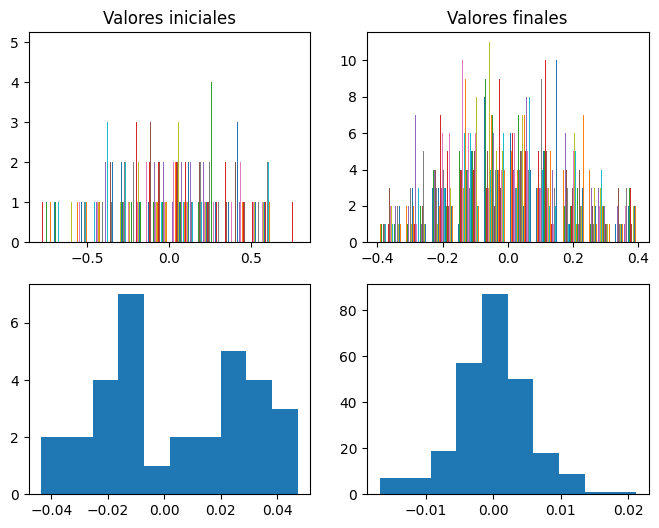

In [113]:
fig, ax = plt.subplots(2, 2, figsize=(8,6),)
ax[0,0].hist(model.get_layer(index=0).get_weights()[0])
ax[1,1].hist(model.get_layer(index=0).get_weights()[1])

ax[0,1].hist(model.get_layer(index=5).get_weights()[0])
ax[1,0].hist(model.get_layer(index=5).get_weights()[1])
ax[0,0].set_title("Valores iniciales")
ax[0,1].set_title("Valores finales")

### Aumentar la tasa de aprendizaje

In [114]:
init = tf.keras.initializers.glorot_uniform()
model=VG(0.05,'tanh', init)
history1 = model.fit(x_tr_1, y_tr, epochs=30, validation_data=(x_val_1,y_val))

Epoch 1/30
17/17 [==============================] - 2s 30ms/step - loss: 0.5250 - val_loss: 0.5272
Epoch 2/30
17/17 [==============================] - 0s 9ms/step - loss: 0.4744 - val_loss: 0.4880
Epoch 3/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4677 - val_loss: 0.4741
Epoch 4/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4646 - val_loss: 0.4756
Epoch 5/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4651 - val_loss: 0.4699
Epoch 6/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4620 - val_loss: 0.4698
Epoch 7/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4588 - val_loss: 0.4610
Epoch 8/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4580 - val_loss: 0.4578
Epoch 9/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4563 - val_loss: 0.4657
Epoch 10/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4539 - val_loss: 0.4606
Epoch 11/3

Text(0.5, 1.0, 'Valores finales')

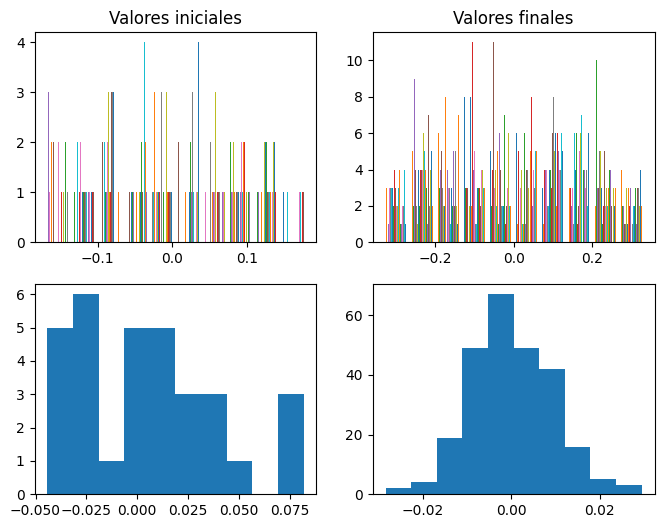

In [115]:
fig, ax = plt.subplots(2, 2, figsize=(8,6),)
ax[0,0].hist(model.get_layer(index=0).get_weights()[0])
ax[1,1].hist(model.get_layer(index=0).get_weights()[1])

ax[0,1].hist(model.get_layer(index=5).get_weights()[0])
ax[1,0].hist(model.get_layer(index=5).get_weights()[1])
ax[0,0].set_title("Valores iniciales")
ax[0,1].set_title("Valores finales")

En los graficos se puede observar como, para los valores finales, la red setea muchos pesos en 0, formando en todos los casos una curva similar a la de una distribución normal 

## 1.k Batch Normalization

Una manera propuesta de mejorar los desempeños de las redes es Batch Normalization. Entrene nuevamente su red preferida de la pregunta anterior, agregando capas de _Batch Normalization_ antes de cada función de activación. Comente sus resultados. Luego pruebe agregando capas de _Batch Normalization_ después de cada función de activación.

¿Qué realiza _Batch Normalization_ en términos matemáticos?. En términos de aprendizaje, ¿Qué evita la utilización de _Batch Normalization_?

¿Mejoran los desempeños de la red agregando _Batch Normalization_?¿Existe diferencias entre una capa de _Batch Normalization_ justo antes o justo después de la función de activación en términos de aprendizaje? Discuta.

In [116]:
from tensorflow.keras.layers import BatchNormalization

In [117]:
def BND(lr,activation):
    model=Sequential()
    # Hidden Layer
    model.add(Dense(units = 256, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 256, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 128, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 128, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 32, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 32, activation = activation))
    model.add(BatchNormalization())
    # Output Layer
    model.add(
        Dense(
           units = 1,
           activation='sigmoid'
        )
    )

    model.compile(
        optimizer=SGD(learning_rate=lr),
        loss='binary_crossentropy'
    )
    return model

def BNA(lr,activation):
    model=Sequential()
    # Hidden Layer
    model.add(BatchNormalization())
    model.add(Dense(units = 256, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 256, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 128, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 128, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 32, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 32, activation = activation))
    # Output Layer
    model.add(
        Dense(
           units = 1,
           activation='sigmoid'
        )
    )

    model.compile(
        optimizer=SGD(learning_rate=lr),
        loss='binary_crossentropy'
    )
    return model

In [118]:
model=BNA(learning_r,'tanh')

history1 = model.fit(x_tr_1, y_tr, epochs=30, validation_data=(x_val_1,y_val))

Epoch 1/30
17/17 [==============================] - 4s 46ms/step - loss: 0.6222 - val_loss: 0.5930
Epoch 2/30
17/17 [==============================] - 0s 11ms/step - loss: 0.5336 - val_loss: 0.5734
Epoch 3/30
17/17 [==============================] - 0s 11ms/step - loss: 0.5139 - val_loss: 0.5571
Epoch 4/30
17/17 [==============================] - 0s 12ms/step - loss: 0.5057 - val_loss: 0.5380
Epoch 5/30
17/17 [==============================] - 0s 11ms/step - loss: 0.5010 - val_loss: 0.5405
Epoch 6/30
17/17 [==============================] - 0s 12ms/step - loss: 0.4771 - val_loss: 0.5347
Epoch 7/30
17/17 [==============================] - 0s 12ms/step - loss: 0.4594 - val_loss: 0.5183
Epoch 8/30
17/17 [==============================] - 0s 12ms/step - loss: 0.4484 - val_loss: 0.5130
Epoch 9/30
17/17 [==============================] - 0s 12ms/step - loss: 0.4400 - val_loss: 0.5206
Epoch 10/30
17/17 [==============================] - 0s 12ms/step - loss: 0.4349 - val_loss: 0.5061
Epoch 11/

In [119]:
model=BND(learning_r,'tanh')
history2 = model.fit(x_tr_1, y_tr, epochs=30, validation_data=(x_val_1,y_val))

Epoch 1/30
17/17 [==============================] - 4s 41ms/step - loss: 0.6435 - val_loss: 0.5853
Epoch 2/30
17/17 [==============================] - 0s 10ms/step - loss: 0.5057 - val_loss: 0.5903
Epoch 3/30
17/17 [==============================] - 0s 11ms/step - loss: 0.4863 - val_loss: 0.5758
Epoch 4/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4648 - val_loss: 0.5563
Epoch 5/30
17/17 [==============================] - 0s 11ms/step - loss: 0.4337 - val_loss: 0.5650
Epoch 6/30
17/17 [==============================] - 0s 11ms/step - loss: 0.4353 - val_loss: 0.5520
Epoch 7/30
17/17 [==============================] - 0s 12ms/step - loss: 0.4142 - val_loss: 0.5603
Epoch 8/30
17/17 [==============================] - 0s 12ms/step - loss: 0.3906 - val_loss: 0.5617
Epoch 9/30
17/17 [==============================] - 0s 12ms/step - loss: 0.3858 - val_loss: 0.5489
Epoch 10/30
17/17 [==============================] - 0s 12ms/step - loss: 0.3861 - val_loss: 0.5460
Epoch 11/

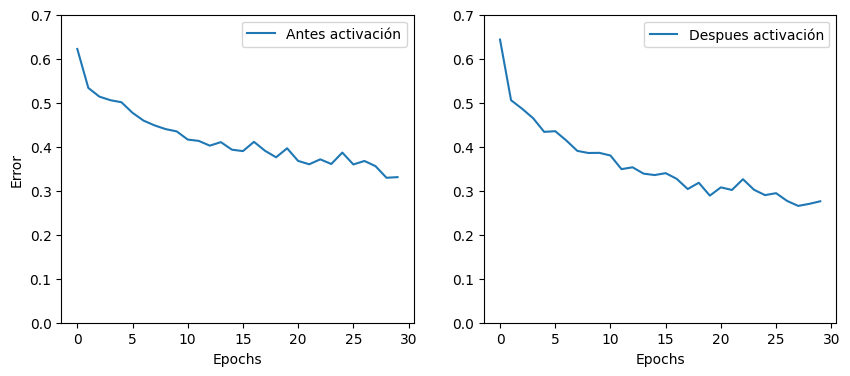

In [120]:
default_x_ticks = range(30)

fig, ax = plt.subplots(1, 2, figsize=(10,4),)

ax[0].set_ylim(0.0,0.7)
ax[1].set_ylim(0.0,0.7)
ax[0].plot(default_x_ticks, history1.history['loss'])
ax[1].plot(default_x_ticks, history2.history['loss'])

ax[0].set_ylabel('Error')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].legend(['Antes activación'], loc='upper right')
ax[1].legend(['Despues activación'], loc='upper right')
plt.show()

En las graficas se puede observar como, al aplicar la capa de batch despues de las capas con funciones de activacion, la red presenta un mejor desempeño

## 1.l Otros Optimizadores

Utilizando la arquitectura de red que mejor se haya desempeñado a lo largo de la tarea, entrene esta red utilizando un optimizador distinto al gradiente descendente estocástico. Pruebe al menos 2 optimizadores implementados en keras (puede utilizar Adam, AdaGrad, AdaDelta, RMSprop, entre otros), también puede probar modificando los parámetros que no hemos utilizado del gradiente descendente estocástico (momentum, momentum de Nesterov...).

Note que por las inicializaciones por defecto de los pesos de las capas y la naturaleza de los datos en cuestión, puede ocurrir que para los valores defecto de algunos optimizadores la red diverga en las primeras iteraciones. Para fijar los parámeros de los optimizadores debe importarlos desde `keras.optimizers` y pasar el objeto con los parámetros deseados al método `.compile` de su modelo. En cambio si con los valores usuales basta, algunos optimizadores pueden pasarse como `string` a `.compile`.

Compare como se desempeñan estos optimizadores con la versión utilizada anteriormente, considerando los tiempos de entrenamiento y el desempeño final alcanzado. Apoyese de gráficos. 

In [121]:
historyloss = []

In [122]:
%%time
model= Drop(256,learning_r,'tanh')
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam())
history = model.fit(x_tr_1, y_tr, epochs=60, validation_data=(x_val_1,y_val))
historyloss.append( history )

Epoch 1/60
17/17 [==============================] - 1s 21ms/step - loss: 0.5788 - val_loss: 0.5723
Epoch 2/60
17/17 [==============================] - 0s 7ms/step - loss: 0.5084 - val_loss: 0.5454
Epoch 3/60
17/17 [==============================] - 0s 7ms/step - loss: 0.4863 - val_loss: 0.5261
Epoch 4/60
17/17 [==============================] - 0s 7ms/step - loss: 0.4698 - val_loss: 0.4927
Epoch 5/60
17/17 [==============================] - 0s 9ms/step - loss: 0.4780 - val_loss: 0.4829
Epoch 6/60
17/17 [==============================] - 0s 8ms/step - loss: 0.4659 - val_loss: 0.4746
Epoch 7/60
17/17 [==============================] - 0s 7ms/step - loss: 0.4696 - val_loss: 0.4744
Epoch 8/60
17/17 [==============================] - 0s 8ms/step - loss: 0.4645 - val_loss: 0.4762
Epoch 9/60
17/17 [==============================] - 0s 8ms/step - loss: 0.4630 - val_loss: 0.4620
Epoch 10/60
17/17 [==============================] - 0s 8ms/step - loss: 0.4750 - val_loss: 0.4666
Epoch 11/60
17/17 

In [123]:
%%time
model= Drop(256,learning_r,'tanh')
model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adadelta())
history = model.fit(x_tr_1, y_tr, epochs=60, validation_data=(x_val_1,y_val))
historyloss.append( history )

Epoch 1/60
17/17 [==============================] - 1s 22ms/step - loss: 0.6866 - val_loss: 0.6717
Epoch 2/60
17/17 [==============================] - 0s 7ms/step - loss: 0.6964 - val_loss: 0.6714
Epoch 3/60
17/17 [==============================] - 0s 7ms/step - loss: 0.7006 - val_loss: 0.6711
Epoch 4/60
17/17 [==============================] - 0s 8ms/step - loss: 0.7008 - val_loss: 0.6707
Epoch 5/60
17/17 [==============================] - 0s 9ms/step - loss: 0.6891 - val_loss: 0.6704
Epoch 6/60
17/17 [==============================] - 0s 10ms/step - loss: 0.7012 - val_loss: 0.6701
Epoch 7/60
17/17 [==============================] - 0s 8ms/step - loss: 0.6844 - val_loss: 0.6698
Epoch 8/60
17/17 [==============================] - 0s 8ms/step - loss: 0.7000 - val_loss: 0.6695
Epoch 9/60
17/17 [==============================] - 0s 8ms/step - loss: 0.6941 - val_loss: 0.6692
Epoch 10/60
17/17 [==============================] - 0s 10ms/step - loss: 0.6879 - val_loss: 0.6688
Epoch 11/60
17/1

In [124]:
%%time
model= Drop(256,learning_r,'tanh')
model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adagrad())
history = model.fit(x_tr_1, y_tr, epochs=60, validation_data=(x_val_1,y_val))
historyloss.append( history )

Epoch 1/60
17/17 [==============================] - 1s 25ms/step - loss: 0.7050 - val_loss: 0.6966
Epoch 2/60
17/17 [==============================] - 0s 8ms/step - loss: 0.6857 - val_loss: 0.6759
Epoch 3/60
17/17 [==============================] - 0s 8ms/step - loss: 0.6618 - val_loss: 0.6596
Epoch 4/60
17/17 [==============================] - 0s 8ms/step - loss: 0.6495 - val_loss: 0.6465
Epoch 5/60
17/17 [==============================] - 0s 8ms/step - loss: 0.6401 - val_loss: 0.6352
Epoch 6/60
17/17 [==============================] - 0s 9ms/step - loss: 0.6221 - val_loss: 0.6259
Epoch 7/60
17/17 [==============================] - 0s 9ms/step - loss: 0.6190 - val_loss: 0.6172
Epoch 8/60
17/17 [==============================] - 0s 8ms/step - loss: 0.6153 - val_loss: 0.6099
Epoch 9/60
17/17 [==============================] - 0s 8ms/step - loss: 0.6020 - val_loss: 0.6035
Epoch 10/60
17/17 [==============================] - 0s 10ms/step - loss: 0.5946 - val_loss: 0.5977
Epoch 11/60
17/17

In [125]:
%%time
model1 = Drop(256,learning_r,'tanh')
model1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop())
history1 = model1.fit(x_tr_1, y_tr, epochs=60, validation_data=(x_val_1,y_val))
historyloss.append( history1 )

Epoch 1/60
17/17 [==============================] - 1s 23ms/step - loss: 0.5417 - val_loss: 0.5751
Epoch 2/60
17/17 [==============================] - 0s 7ms/step - loss: 0.4974 - val_loss: 0.5428
Epoch 3/60
17/17 [==============================] - 0s 7ms/step - loss: 0.4842 - val_loss: 0.5151
Epoch 4/60
17/17 [==============================] - 0s 7ms/step - loss: 0.4778 - val_loss: 0.5072
Epoch 5/60
17/17 [==============================] - 0s 8ms/step - loss: 0.4679 - val_loss: 0.4938
Epoch 6/60
17/17 [==============================] - 0s 8ms/step - loss: 0.4714 - val_loss: 0.4823
Epoch 7/60
17/17 [==============================] - 0s 7ms/step - loss: 0.4713 - val_loss: 0.4805
Epoch 8/60
17/17 [==============================] - 0s 10ms/step - loss: 0.4693 - val_loss: 0.4765
Epoch 9/60
17/17 [==============================] - 0s 8ms/step - loss: 0.4697 - val_loss: 0.4837
Epoch 10/60
17/17 [==============================] - 0s 8ms/step - loss: 0.4744 - val_loss: 0.4801
Epoch 11/60
17/17

In [126]:
time=[17.7,15.8,16.8,16.4]

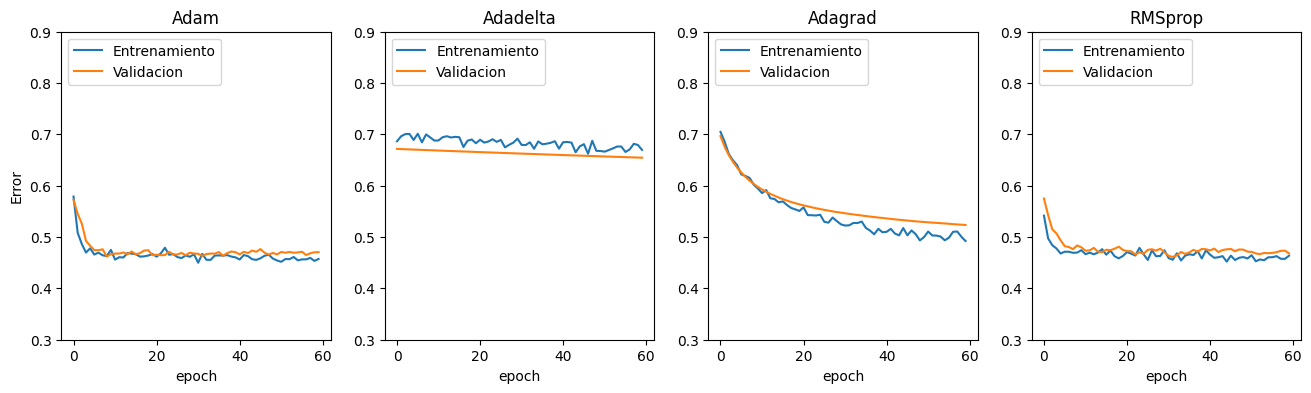

In [127]:
fig, ax = plt.subplots(1, 4, figsize=(16,4),)
title = ["Adam", "Adadelta", "Adagrad", "RMSprop"]

for i in range(4):
    ax[i].set_ylim(0.3,0.9)
    ax[i].plot(range(60), historyloss[i].history['loss'])
    ax[i].plot(range(60), historyloss[i].history['val_loss'])
    ax[i].legend(['Entrenamiento', 'Validacion'], loc='upper left')
    ax[i].set_title(title[i])
    ax[i].set_xlabel("epoch")

ax[0].set_ylabel('Error')
plt.show()

En las graficas se puede observar el rendimiento de los distintos optimizadores, donde al firnal, adam y RMSprop son los que tienen un mejor rendimiento

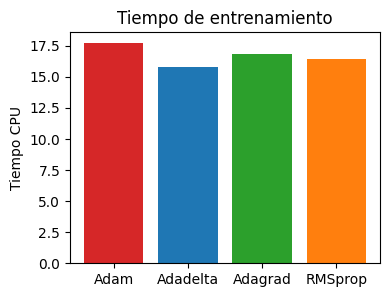

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(4,3),)

Column = ["Adam", "Adadelta", "Adagrad", "RMSprop"]

bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']

ax.bar(Column, time, color=bar_colors)

ax.set_ylabel('Tiempo CPU')
ax.set_title('Tiempo de entrenamiento')

plt.show()

Siguiendo con el grafico anterior, aca se puede observar el tiempo de ejecucion que demoro cada optimizador, siendo adam el que mas se demora y adadelta el que presenta los menores tiempos

## 1.m Testing 

Finalmente, luego de entrenar todos estos modelos estamos en condiciones de probar que tan bien fue nuestro desempeño. Para esto utilice el modelo en el cual obtuvo el mejor desempeño en validación y calcule el error de la predicción realizada sobre el _Test set_. Puede utilizar el metodo `.predict` de su modelo. 

¿Qué tan bien se desempeñaría su modelo en un caso real en vista de lo anterior? 

In [129]:
X_test[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = X_test[['Glucose',
'BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
X_test = X_test.fillna(X_test.mean())

In [130]:
modelo_final=Drop(256,learning_r,'tanh')
results = modelo_final.evaluate(X_test, y_test)
print("test loss, test acc:", results)

3/3 [==============================] - 0s 7ms/step - loss: 0.8631
test loss, test acc: 0.8631241321563721


Considerando que se tomaron los elementos que mayor desempeño nos dieron, nuestro modelo, teoricamente hablando, deberia tener un buen desempeño en el dataset de testing. Si vemos la ultima celda, vemos que la prediccion del modelo sobre el conjunto de testing nos retorna un $86.3$ de precision, el cual es un valor aceptable de rendimiento frente a un "caso real".

Frente a esto, como grupo podemos concluir que nuestra red tendria un rendimiento mas que aceptable para los casos reales.